Simulation model 1

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from cmcrameri import cm as cmc
import pandas as pd
import xarray as xr
import itertools


import pdb
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
from scipy.stats import norm, beta, bernoulli


import ml_estimation as ml
import ml_estimation2 as ml2
import model1_plots as mp
import model1_explore as me
import model1_sim as sim1
import Utilities as util

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

## parameters from fit

In [12]:
ds = xr.open_dataset('../mod/model2/dH=500_dD=0_5_N=5000local_param.nc')

# ds_m1_c = xr.open_dataset('../mod/model1/expl_local_param.nc')
# ds_m1_cs= xr.open_dataset('../mod/model1/glob_theta.nc')[['theta1', 'theta3']]

# ds_theta#.theta1, ds_theta.theta3
# ds_localda

In [13]:
ds

<xarray.Dataset>
Dimensions:              (cs_mu_dN: 11, cs_mu_hN: 63, est: 2, method: 2, mu_csf: 10, mu_d: 28, mu_dN: 8, mu_h: 79, mu_hN: 13, n_or_val: 2, var_cod: 2, var_cth_b: 2, var_cth_bm: 5)
Coordinates: (12/13)
  * mu_h                 (mu_h) float64 100.0 300.0 500.0 ... 1.55e+04 1.57e+04
  * mu_d                 (mu_d) float64 -1.0 -0.8 -0.6 -0.4 ... 3.8 4.0 4.2 4.4
  * mu_hN                (mu_hN) float64 -1.5e+03 -1.25e+03 ... 1.25e+03 1.5e+03
  * mu_dN                (mu_dN) float64 -0.8 -0.55 -0.3 -0.05 0.2 0.45 0.7 0.95
  * cs_mu_hN             (cs_mu_hN) float64 250.0 500.0 ... 1.55e+04 1.575e+04
  * cs_mu_dN             (cs_mu_dN) float64 -1.0 -0.5 0.0 0.5 ... 3.0 3.5 4.0
    ...                   ...
  * n_or_val             (n_or_val) object 'val' 'n'
  * method               (method) object 'ML' 'MoM'
  * est                  (est) object 'coef' 'bse'
  * var_cth_bm           (var_cth_bm) object 'mu1' 'nu1' 'mu2' 'nu2' 'p'
  * var_cod              (var_cod) object 'mu' 'sigma'
  * var_cth_b            (var_cth_b) object 'alpha' 'beta'
Data variables:
    p_cs                 (mu_h, mu_d, mu_csf, n_or_val) float64 ...
    param_cod            (mu_h, mu_d, mu_dN, var_cod, n_or_val) float64 ...
    param_cth_bm         (mu_h, mu_d, mu_hN, est, var_cth_bm, n_or_val) float64 ...
    cs_n                 (cs_mu_hN, cs_mu_dN, mu_csf) float64 ...
    cs_p_cs              (mu_csf) float64 ...
    cs_param_cod         (cs_mu_dN, var_cod) float64 ...
    cs_param_cth_bm      (cs_mu_hN, est, var_cth_bm) float64 ...
    cs_csf_param_cod     (var_cod) float64 ...
    cs_csf_param_cth_bm  (est, var_cth_bm) float64 ...

## Fill nan values 

In [14]:
def interpolateNN(var, dim):
    
    for i in range(len(var[dim])): 
        val = var[dim][i]
        temp = var.loc[{dim : val}]
        for j in range(len(var[dim])):
    #         print(j)
    #         print(val.data)
            if val > 0:
                j = -j
            if j > len(var[dim])/2:
                continue
            val1 = var[dim][i + j]
            if (val1 == 0):
                continue
            temp1 = var.loc[{dim : val1}]
            temp = temp.where(~np.isnan(temp), temp1) 

    #     temp.loc[np.isnan(temp)] = temp1.where(np.isnan(temp))
        var.loc[{dim : val}] = temp
    return var

# var = interpolateNN(var, dim)
#     break

# var.sel(var_cth_bm = 'p').plot(col = 'mu_hN')
# plt.show()
# var.where(var)
# # ds.param_cth_bm.sel(est = 'coef', var_cth_bm = 'mu1').plot(col = 'mu_hN')
# diff = var - var.sel(mu_hN = 0)
# diff.sel(var_cth_bm = 'p').plot(col = 'mu_hN')
# # var.
# plt.show()
# var

In [105]:
## from cloud 
ds = xr.open_dataset('../mod/model2/dH=500_dD=0_5_N=5000local_param.nc')

# p_cs
n_loc = dict(n_or_val = 'n')
n = ds.p_cs.loc[n_loc]


dummy = ds.p_cs.loc[dict(n_or_val = 'val')].where(n > 100).interpolate_na(
    dim = 'mu_csf', method = 'zero', fill_value = 'extrapolate')
ds.p_cs.loc[dict(n_or_val = 'val')] = dummy


# cod (mu, sigma)
n_loc = dict(var_cod = 'mu', n_or_val = 'n')
n = ds.param_cod.loc[n_loc]
ds.param_cod.loc[dict(n_or_val = 'val')] = ds.param_cod.loc[
        dict(n_or_val = 'val')].where(n > 100)

ds.param_cod.loc[dict(n_or_val = 'val')]= interpolateNN(ds.param_cod.loc[dict(n_or_val = 'val')], 'mu_dN')


# cth ()
n_loc = dict(var_cth_bm = 'mu1', n_or_val = 'n', est = 'coef')
n = ds.param_cth_bm.loc[n_loc]
ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')] = ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')].where(
    n > 1000)

ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')] = interpolateNN(ds.param_cth_bm.loc[dict(est = 'coef', n_or_val = 'val')], 'mu_hN')


# clear sky contains nans as well for cth
n = ds.cs_n.sum(dim = ('cs_mu_dN', 'mu_csf'))
ds.cs_param_cth_bm.loc[dict(est = 'coef')] = ds.cs_param_cth_bm.sel(est = 'coef').where(n > 1000)

ds.cs_param_cth_bm.loc[dict(est = 'coef')] = interpolateNN(ds.cs_param_cth_bm.loc[dict(est = 'coef')], 'cs_mu_hN')

### if not available turn to model 1
# x = (8000, 5)
# model 1
mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
# ds1 = sim1.param_c(mu_h, mu_d, ds_m1_c, method = 'nearest')
# ds1 = ds1.loc[dict(est = 'coef', method = 'ML')]

# p_cs = sim1.theta_c_to_cs(*x, ds1 , method = 'nearest')
# cth_param = sim1.theta_c_to_c_cth(*x, ds1, method = 'nearest')
# cod_param = sim1.theta_c_to_c_cod(*x, ds1, method = 'nearest')
# p_cs, cth_param, cod_param
ds = ds.loc[dict(n_or_val = 'val')]



ds_temp_d = ds.param_cth_bm.sel(mu_h = ds.mu_h[ds.mu_h < 14700], est = 'coef').interpolate_na(dim = 'mu_d', method = 'nearest', fill_value="extrapolate")
ds['param_cth_bm'] = ds_temp_d
ds
# ds_temp_h = ds.interpolate_na(dim = 'mu_h', method = 'nearest', fill_value="extrapolate")
# ds['p_cs'] = ds_temp_h.p_cs
# ds['param_cod'] = ds_temp_h.param_cod

ds = ds.interpolate_na(dim = 'mu_h', method = 'nearest', fill_value="extrapolate")



In [101]:
(ds.param_cth_bm.sel(est = 'coef')).where((ds.param_cth_bm.sel(est = 'coef').count(dim = 'mu_d') == 0), drop = True)
temp = ds.param_cth_bm.sel(mu_h = ds.mu_h[ds.mu_h < 14700]).sel(est = 'coef')

temp.where(temp.count(dim = 'mu_d'), drop = True)

temp.count(dim = ['mu_d'])

ValueError: dimensions or multi-index levels ['est'] do not exist

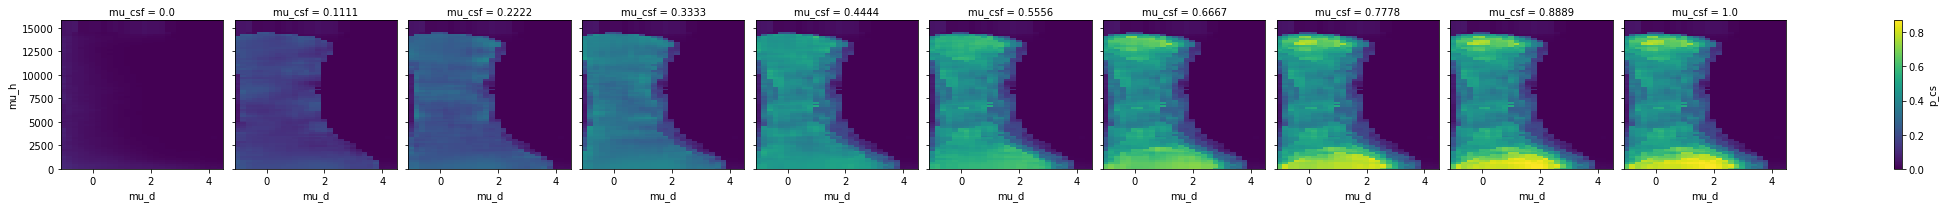

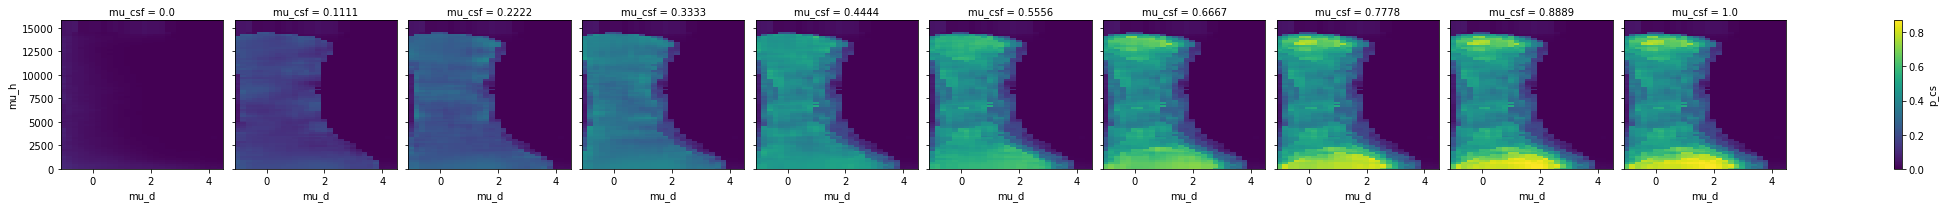

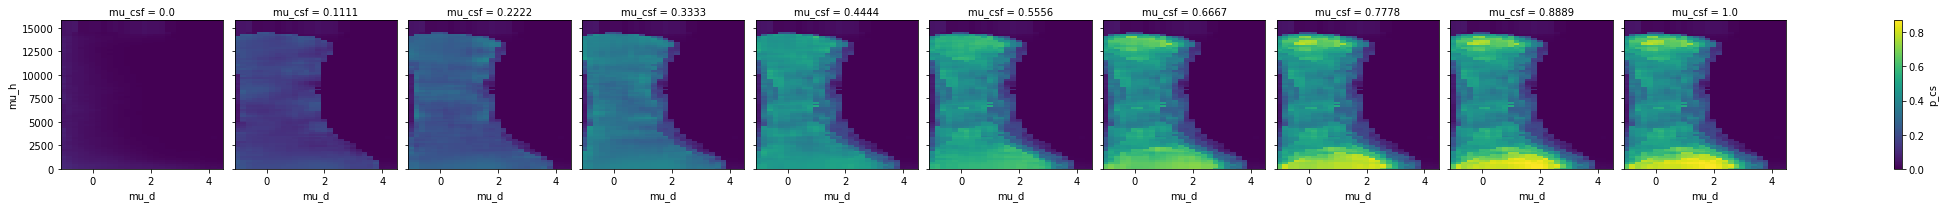

In [102]:
ds.p_cs.plot(col = 'mu_csf')
ds_temp = ds.interpolate_na(dim = 'mu_h', method = 'nearest', fill_value="extrapolate")

ds_temp.p_cs.plot(col = 'mu_csf')
ds['p_cs'] = ds_temp.p_cs
ds.p_cs.plot(col = 'mu_csf')


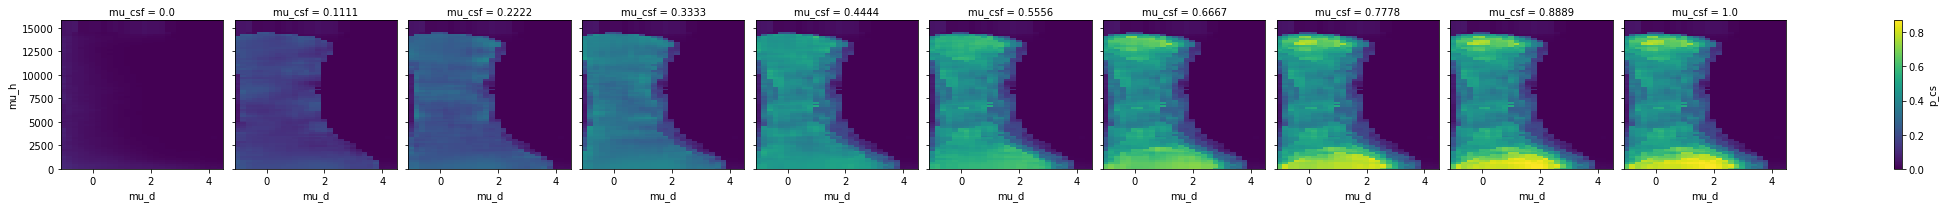

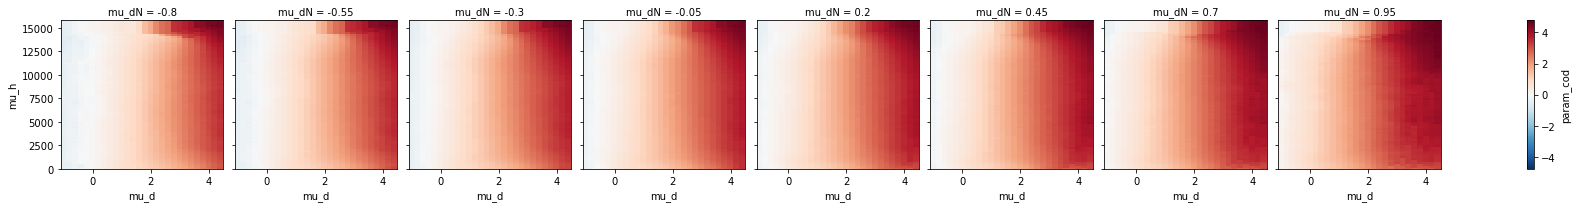

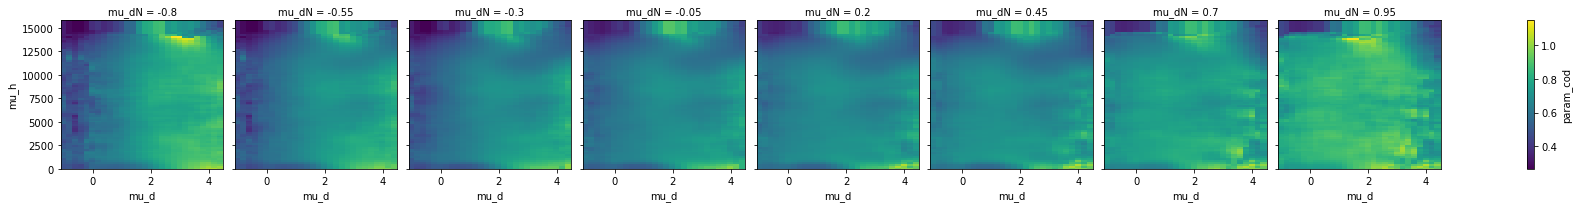

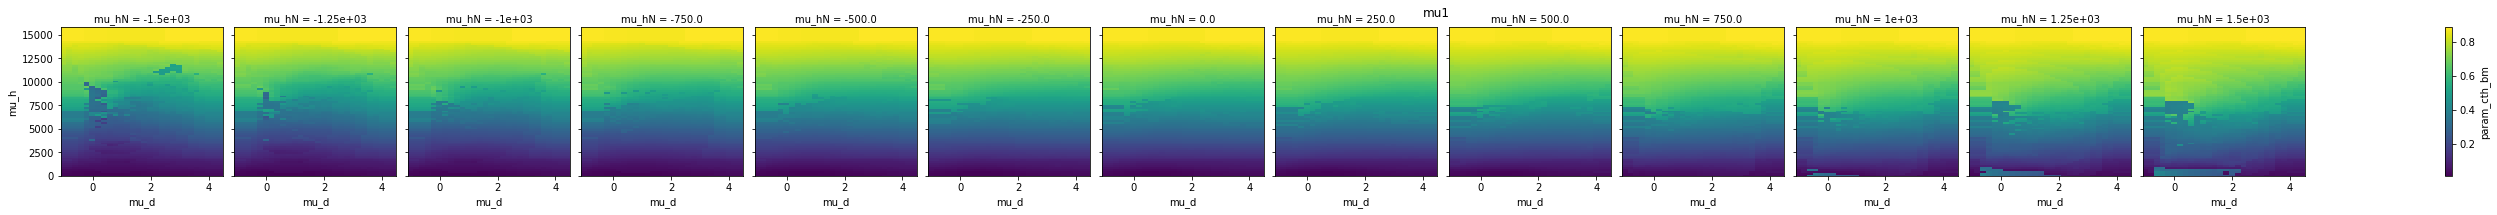

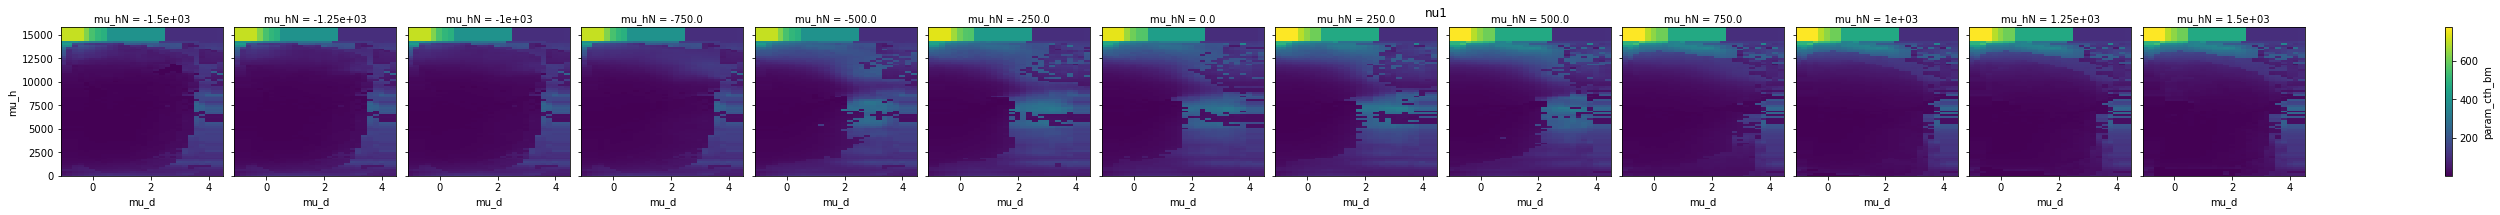

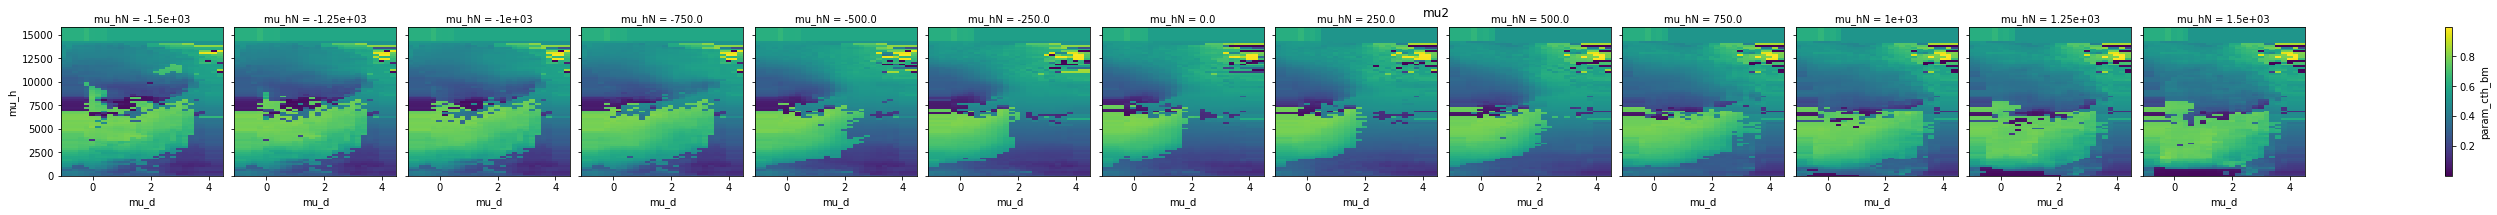

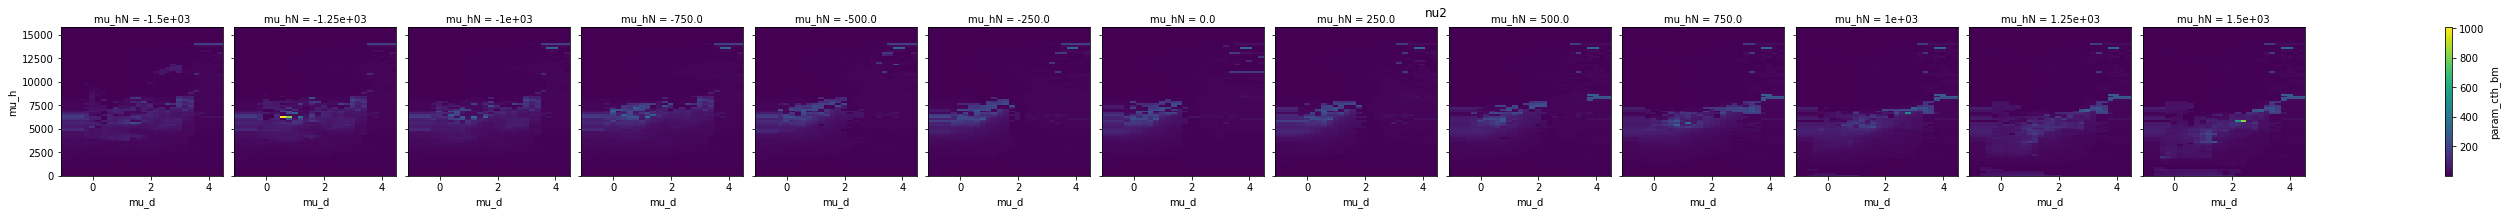

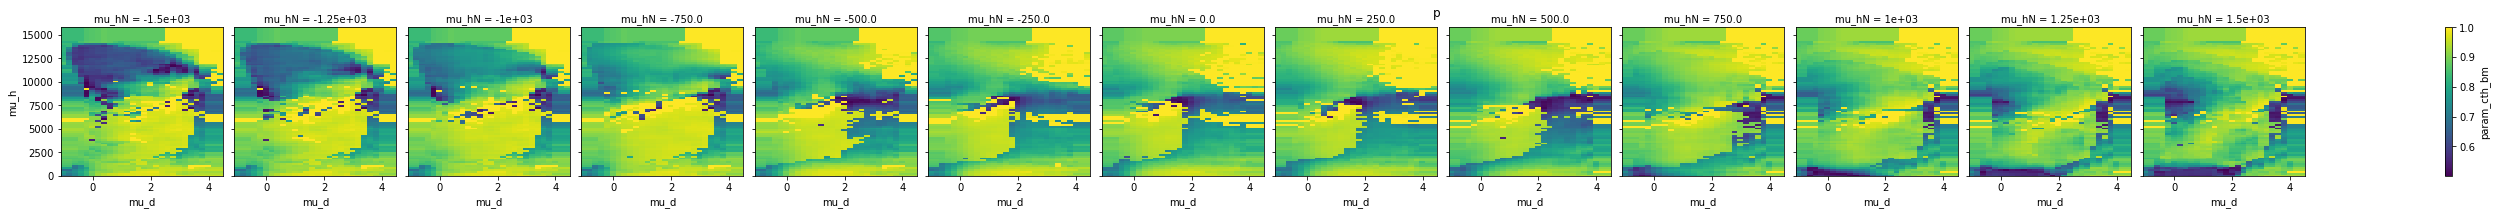

In [106]:
ds.p_cs.plot(col = 'mu_csf')
ds.param_cod.sel(var_cod = 'mu').plot(col = 'mu_dN')
ds.param_cod.sel(var_cod = 'sigma').plot(col = 'mu_dN')

# ds.param_cth_bm.sel(est = 'coef').plot(col = 'mu_hN', row = 'var_cth_bm')


for theta in ds.var_cth_bm:
    ds.param_cth_bm.sel(var_cth_bm = theta).plot(col = 'mu_hN')
    plt.suptitle(theta.data)
#     print(theta)

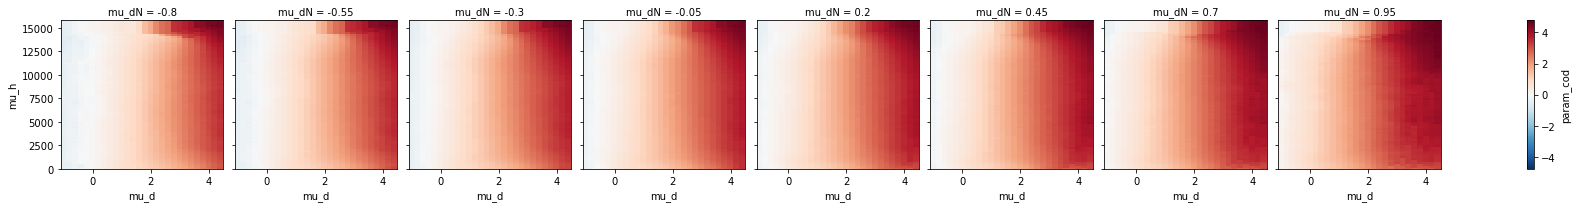

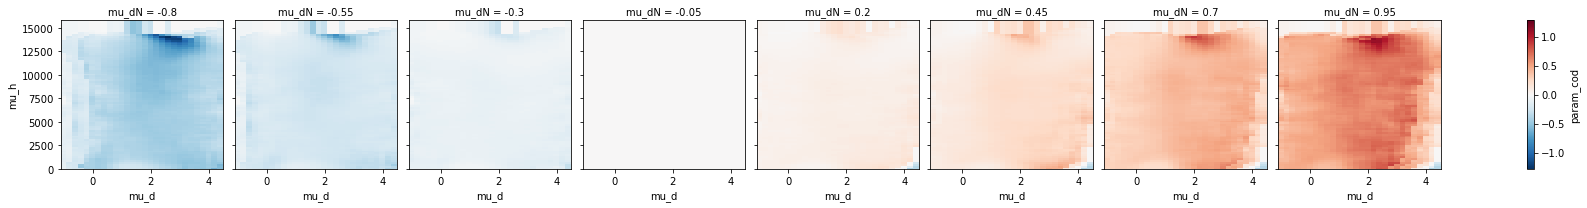

In [18]:

var = ds.param_cod#, var_cth_bm = 'mu1')
dim = 'mu_dN'
var.sel(var_cod = 'mu').plot(col = 'mu_dN')
plt.show()
diff = var - var.sel(mu_dN = ds.mu_dN[3])
diff.sel(var_cod = 'mu').plot(col = 'mu_dN')

In [19]:
def get_param(ds, loc, method = 'nearest'): # think more about interpolation method once we have the fll data
#     ds_c.interpolate_na(dim = 'mu_d', method = method, fill_value = 'extrapolate')
    return ds.interp(loc, method = method, kwargs={"fill_value": "extrapolate"})

In [20]:
est = get_param(ds.p_cs, dict(mu_h = 8000, mu_d = 5, mu_csf = .8))
# if np.isnan(est):
    
x = (8000, 5)
# model 1
mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
# ds1 = sim1.param_c(mu_h, mu_d, ds_m1_c, method = 'nearest')
# ds1 = ds1.loc[dict(est = 'coef', method = 'ML')]

# p_cs = sim1.theta_c_to_cs(*x, ds1 , method = 'nearest')
# cth_param = sim1.theta_c_to_c_cth(*x, ds1, method = 'nearest')
# cod_param = sim1.theta_c_to_c_cod(*x, ds1, method = 'nearest')
# p_cs, cth_param, cod_param
# np.isnan(p_cs)

In [21]:
get_param(ds.cs_p_cs, dict(mu_csf = 1))

<xarray.DataArray 'cs_p_cs' ()>
array(0.94628955)
Coordinates:
    n_or_val  <U3 'val'
    mu_csf    int32 1

## Simulation Functions

In [113]:
def step_pixel(z, h, d, csf, h_bar, d_bar, ds, method = 'standard'):
    """Makes one step.
    Args:
        x (np.array(6,)):                
            current full state Y of the pixel (z, h, d, csf, h_bar, d_bar)
        ds xarray with parameter estimates
    Returns:
        np.array (3,): updated state of the pixel (z, h, d)
    """
    
    
    if method not in ('standard', 'main_beta'):
        raise NotImplementedError("%s is unsupported: Use standard or main_beta " % method)
    
    ## p_cs
    if z: 
        loc = dict(mu_csf = csf)
        p_cs = get_param(ds.cs_p_cs, loc)
    else: 
        loc = dict(mu_h = h, mu_d = d, mu_csf = csf)
        p_cs = get_param(ds.p_cs, loc)
        h_bar = h_bar - h
        d_bar = d_bar - d
    
#     print('x and p_cs', x, p_cs)
    
    # to cloud or clear sky
    z_next = bernoulli.rvs(p_cs)
    
    if z_next: # if there is a cloud (h, d)next are not defined
        h_next, d_next = np.nan, np.nan
    else:     
        if z: 
            if csf: ## x current is a clear sky and is only surrounded by cs
            # then h_bar and d_bar ar NaN
                cod_param = ds.cs_csf_param_cod.data
                cth_param = ds.cs_csf_param_cth_bm.sel(est = 'coef').data
            else:

                loc = dict(cs_mu_dN = d_bar)
                cod_param = get_param(ds.cs_param_cod, loc).data
                loc = dict(cs_mu_hN = h_bar)
                cth_param = get_param(ds.cs_param_cth_bm.loc[dict(est = 'coef')], loc).data
#             pdb.set_trace()
        else: ## x is cloud:
            loc = dict(mu_h = h, mu_d = d, mu_dN = d_bar)
            cod_param = get_param(ds.param_cod, loc).data
            loc = dict(mu_h = h, mu_d = d, mu_hN = h_bar)
            cth_param = get_param(ds.param_cth_bm#.loc[dict(est = 'coef')]
                                  , loc).data
            
#         print(cod_param.data, cth_param.data)
        mu, sigma = cod_param
        alpha1, beta1, alpha2, beta2, p = ml2.mixmnToab(*cth_param.data)
        
#         print(mu, sigma)
        d_next = (np.random.randn(1) * sigma + mu) 
        
#         print(cth_param)
        x = np.random.rand(1)
        y1 = beta.rvs(alpha1, beta1)
        
        if method == 'main_beta':
            p = 1
        
        if p == 1:
            h_next = ml.UnitInttoCTH(y1)
        else:
            y2 = beta.rvs(alpha2, beta2)
            u = (x < p)
        #     print('u, y1, y2', u, y1 ,y2)
            h_next = ml.UnitInttoCTH(u * y1 + ~u * y2)
    
    
    return np.hstack([z_next, h_next, d_next])

In [38]:
def neighborhood(ds, i, j,
                 n = 1 # neighbor degree
                 ):

    xlow = max(0, i - n)
    xupper = min(ds.dims['i'], i + n + 1)
    
    ylow = max(0, j - n)
    yupper = min(ds.dims['j'], j + n + 1)
    
    N = (slice(xlow, xupper, 1), slice(ylow, yupper, 1))
    
    return N

def simulation(T, X0, **kwargs):
    X = X0.copy(deep = True)
    t = 0
    for t in range(T):
        print(f't = {t}')
        if t == 0 :
            Xt = X0.copy(deep = True)
        else:
            Xt = X.sel(t = t)
        X_next = X0.copy(deep = True)
        for i, j in itertools.product(Xt.i.data, Xt.j.data):
            N = neighborhood(Xt, i, j)
            pix = dict(i = i, j = j)
            y = [Xt.z[pix], Xt.h[pix], Xt.d[pix], 
                 Xt.z[N].mean(), Xt.h[N].mean(), Xt.d[N].mean()]
        #     print(pix)
        #     print(y)
            y = np.array([yi.data for yi in y])
        #     print('y = ', y)
    #         print('x = ', y[:3])
            if np.isnan(y[0]):
                continue
            x_next = step_pixel(*y, ds, **kwargs)
    #         print('x_n =',x_next)
            X_next.z.loc[pix] = x_next[0]
            X_next.h.loc[pix] = x_next[1]
            X_next.d.loc[pix] = x_next[2]
        #     X_next.loc[pix]
        X_next['t'] = t+1
        X = xr.concat([X, X_next], dim = 't')
        X_next = None
    return X

## setup artificial start

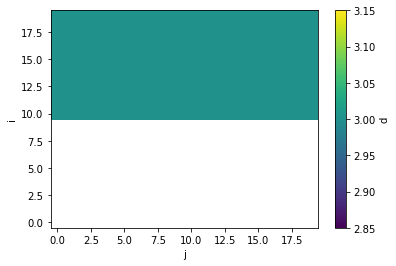

<xarray.Dataset>
Dimensions:  (i: 20, j: 20)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    h        (i, j) float64 nan nan nan nan nan ... 3e+03 3e+03 3e+03 3e+03
    d        (i, j) float64 nan nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0 3.0
    z        (i, j) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [24]:
N, M = 20, 20
np.random.seed(0)
X0 = None

X0 = xr.Dataset(
    data_vars=dict(
        h = (['i', 'j'], np.random.randn(int(N), M)*100 * 0  + 3000), 
        d = (['i', 'j'], np.random.randn(N, M)/2 * 0 + 3), 
        z = (['i', 'j'], np.zeros((N,M))), 
    ),
    coords=dict(
        i = np.arange(N),
        j = np.arange(M)
    ),
    # attrs=dict(dh = dh, dd = dd
    # ),
    )

X0.z[:N//2, :] = 1
X0['h'] = X0.h.where(X0.z == 0)
X0['d'] = X0.d.where(X0.z == 0)
X0.d.plot()
plt.show()
X_next = None
X0

In [25]:
### simulation

T = 3 #30

Xa = simulation(3, X0)
    

t = 0
t = 1
t = 2


In [ ]:
ds.param_cth_bm.sel(est = 'coef', var_cth_bm = 'mu1').plot(col = 'mu_hN')

## Setup original image

In [6]:
loc_clean_data = '../data/clean_data/'
import pickle
from datetime import datetime 
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

# print(dates)
date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]

file = dates.file_name.loc[0]
images = xr.open_dataset(file)
images

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    images = xr.open_dataset(file)
    dss.append(images)

images = xr.concat(dss, 't')

invalid =np.sum(images.ct == 0, axis = (1,2))
images = images.where(invalid < 10000, drop = True)

images = images.rename(dict(x = 'i', y = 'j'))
images = images.rename(dict(cth = 'h', cod = 'd'))

images['i'] = range(len(images.i))
images['j'] = range(len(images.j))
images['d'] = np.log(images.d)
images['z'] = (['t', 'i', 'j'], np.select([images.ct == 1, images.ct > 1], [1, 0], np.nan))
images['z'] = images.z.where(~np.isnan(images.d) & ~np.isnan(images.h) )
images = images.where(images.z == 0)

In [ ]:
# images.z.sel(t = images.t[0]).plot()
# plt.show()
# images.d.sel(t = images.t[0]).plot()
# plt.show()

images

t = 0
t = 1
t = 2
t = 0
t = 1
t = 2


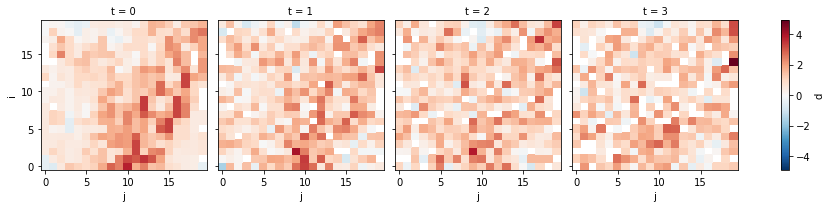

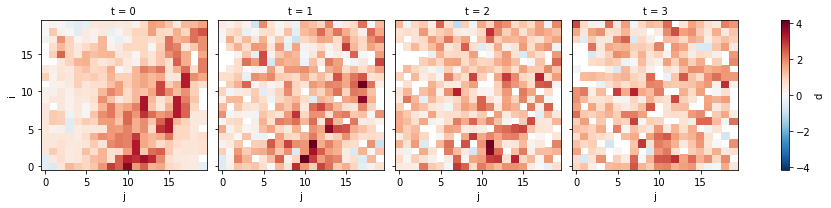

In [114]:
N = 20
T = 3
X0 = images.sel(t = images.t[0], i = images.i[:N], j = images.j[:N])
X0['t'] = 0
Xo = simulation(T, X0, method = 'standard')
# X0.d.plot()
Xo.d.plot(col = 't')

Xo2 = simulation(T, X0, method = 'main_beta')
# X0.d.plot()
Xo2.d.plot(col = 't')

<xarray.DataArray 'h' (i: 20, j: 20)>
array([[  546.49634 ,   132.74545 ,   337.246   ,   522.34296 ,
          704.29877 ,   792.5545  ,   242.04807 ,  1408.1381  ,
         1644.8936  ,   756.286   ,  2154.5508  ,  2949.5647  ,
         3190.4387  ,   235.60492 ,  4090.2634  ,  9446.079   ,
        10857.026   ,  9301.67    , 10088.234   ,   653.35706 ],
       [ 1158.9188  ,   293.62207 ,   338.65872 ,   598.92706 ,
           69.87078 ,          nan,  1350.9697  ,   890.88696 ,
         1987.3671  ,  1756.9977  ,  1676.521   ,  2143.3594  ,
         2185.2358  ,  3858.6787  ,  7774.468   , 12364.976   ,
        11186.075   , 10611.925   , 12812.937   ,          nan],
       [ 1049.3586  ,   325.15033 ,          nan,  1338.7725  ,
          870.97876 ,          nan,   274.9283  ,  1789.74    ,
          841.6374  ,  1489.3419  ,  1827.9865  ,  2412.4814  ,
         1532.532   ,          nan,   657.408   , 12571.996   ,
         5017.7866  ,  1716.3225  , 13286.66    , 10046.037   ],
       [  102.914505,   578.59906 ,    75.08174 ,   223.53291 ,
                 nan,  1384.4253  ,   691.25507 ,          nan,
         1298.1595  ,          nan,  1437.8364  ,  1239.5404  ,
         1143.3865  ,   249.25151 ,  1065.1804  ,  1593.2202  ,
          409.04086 ,   588.87006 ,          nan,   649.29877 ],
...
         1730.3458  ,   281.30035 ,   579.3466  ,  2342.8806  ,
         3694.2554  ,  1454.5703  ,  1403.1736  ,   488.6272  ,
          322.03177 ,   779.2766  ,   600.77625 ,   448.95407 ,
         1554.7917  ,  2262.705   ,  7667.3164  ,  2690.9082  ],
       [  178.54495 ,          nan,   942.8339  ,  1467.3477  ,
          446.40256 ,  1597.8391  , 11749.817   ,   154.36746 ,
         1606.8323  ,          nan,  5189.649   ,  1625.2719  ,
          199.82948 ,   218.86502 ,   853.0353  ,   252.90567 ,
          274.0827  ,  2809.5867  ,  9750.029   ,  5437.87    ],
       [  882.1554  ,  2798.1423  , 13399.511   ,  6411.215   ,
         1456.3207  ,  8817.87    , 12339.055   , 12252.825   ,
        12591.491   , 12244.548   ,   653.32495 ,  4097.2847  ,
         6914.7466  ,  1183.946   ,   911.0777  ,   806.1203  ,
          406.8384  ,  8766.956   ,  6856.803   ,  4854.7285  ],
       [ 4082.0107  ,  2900.428   , 10277.475   ,   728.05634 ,
         6138.183   ,  3219.7407  ,  9602.704   , 12125.868   ,
        13077.56    , 11707.079   ,  1783.4624  , 11978.513   ,
          273.62857 ,   691.49646 ,   650.1662  ,   945.1467  ,
         3094.416   ,  7074.7573  ,  6914.7764  , 10972.966   ]],
      dtype=float32)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
    t        int64 2

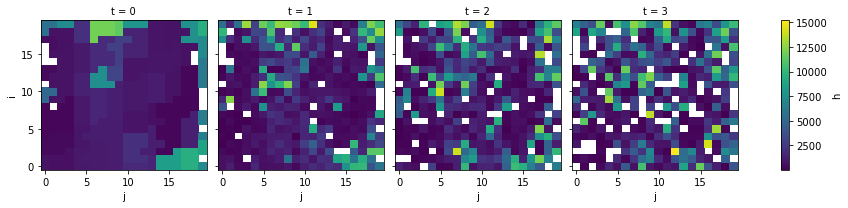

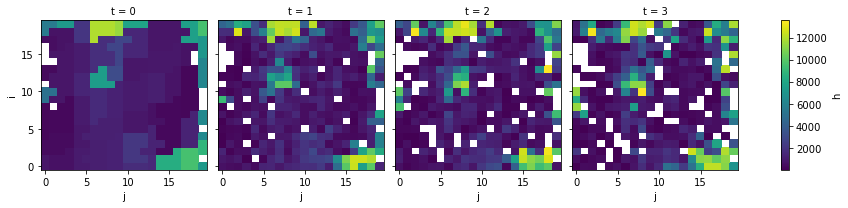

In [115]:
Xo.h.plot(col = 't')
Xo2.h.plot(col = 't')
Xo2.h.sel(t = 2)

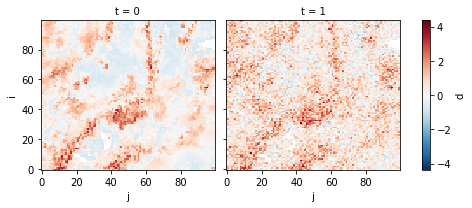

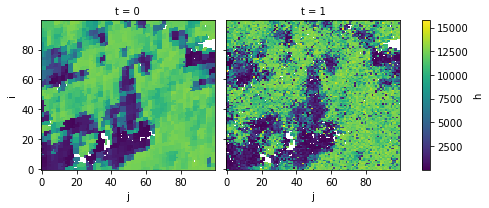

In [31]:
Xo.d.plot(col = 't')
Xo.h.plot(col = 't')

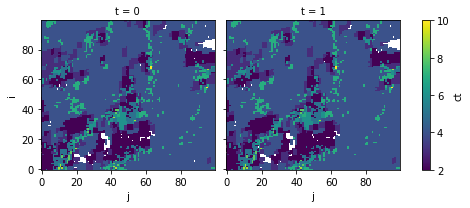

In [34]:
Xo.ct.plot(col = 't')

## Visualization

In [ ]:
def rgb(z, h, d, c = .92):
    blue = (.11, .11, .69)
    if z:
        return blue
    else: 
        h_, d_ = ml.CTHtoUnitInt(h), sim1.toInt((d + 1)/5, [0, 1])
        color = (            
            (h_) * c, 
            (-d_ + 1) * c  , 
            (-d_ + h_ + 1) * 0 + .8)
        return color
rgb(0, 1000, 4)

In [ ]:
X = Xo
X['RGB'] = (['i', 'j','t', 'color'], np.zeros((len(X.i),len(X.j), len(X.t), 3)))
ds['RGB_colorbar'] = (['mu_h', 'mu_d', 'color'], np.zeros((len(ds.mu_h),len(ds.mu_d), 3)))

for i, j, t in itertools.product(X.i.data, X.j.data, X.t.data):
    pix = X.sel(i = i, j = j, t = t)
#     print( data.RGB.loc[dict(i = i , j = j)])
    X.RGB.loc[dict(i = i , j = j, t = t)] = np.array(rgb(pix.z.data, pix.h.data, pix.d.data))

for h, d in itertools.product(ds.mu_h, ds.mu_d):
#     print( data.RGB.loc[dict(i = i , j = j)])
#     print(h)
    ds.RGB_colorbar.loc[dict(mu_d = d, mu_h = h)] = np.array(rgb(0, h.data, d.data))
    

In [25]:
type(t) == int
images

<xarray.Dataset>
Dimensions:  (i: 441, j: 443, t: 39)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 432 433 434 435 436 437 438 439 440
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 434 435 436 437 438 439 440 441 442
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...
Data variables:
    h        (t, i, j) float32 778.9 642.8 642.8 642.8 ... nan nan nan nan
    d        (t, i, j) float32 -0.4316 -0.6445 0.5231 1.334 ... nan nan nan nan
    ct       (t, i, j) float64 2.0 2.0 2.0 5.0 2.0 2.0 ... nan nan nan nan nan
    u        (t, i, j) float32 -6.837 5.984 5.984 5.984 ... nan nan nan nan
    v        (t, i, j) float32 -31.92 11.99 11.99 11.99 ... nan nan nan nan
    z        (t, i, j) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    extent:   [-50. -30.  -5.  15.]

In [4]:
X = xr.open_dataset('..\mod\model2\simsimulation2_T50_N40_image_20201210-15h1457.nc')
# "C:\Users\nerin\OneDrive - Usman\TU_Delft\4_Thesis\ThesisCode\mod\model2\simsimulation2_T50_N40_image_20201210-15h1457.nc"
X

<xarray.Dataset>
Dimensions:  (i: 40, j: 40, t: 51)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 30 31 32 33 34 35 36 37 38 39
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 30 31 32 33 34 35 36 37 38 39
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50
Data variables:
    h        (t, i, j) float32 ...
    d        (t, i, j) float32 ...
    ct       (t, i, j) float64 ...
    u        (t, i, j) float32 ...
    v        (t, i, j) float32 ...
    z        (t, i, j) float64 ...
Attributes:
    extent:   [-50. -30.  -5.  15.]

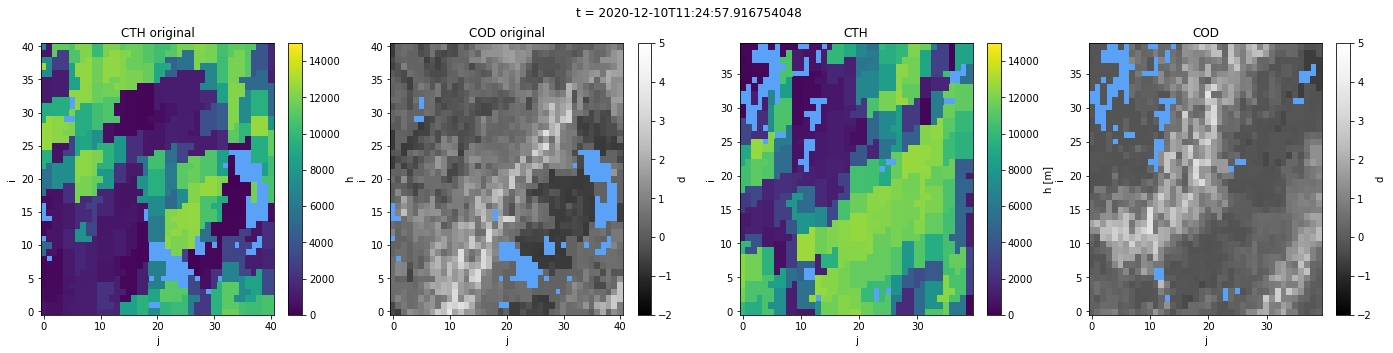

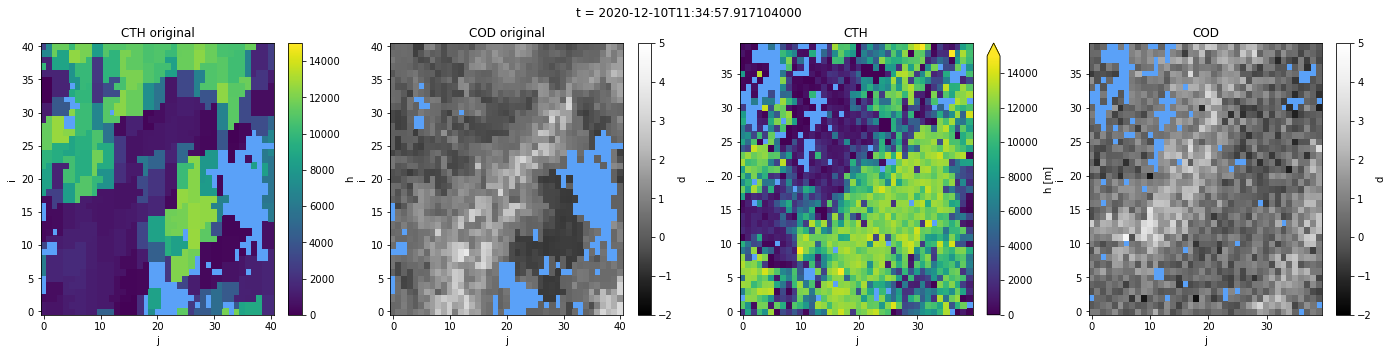

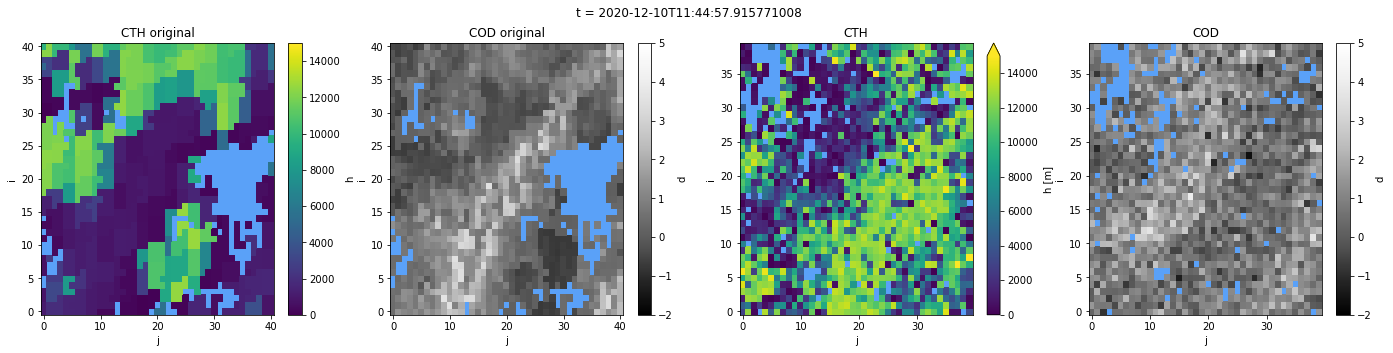

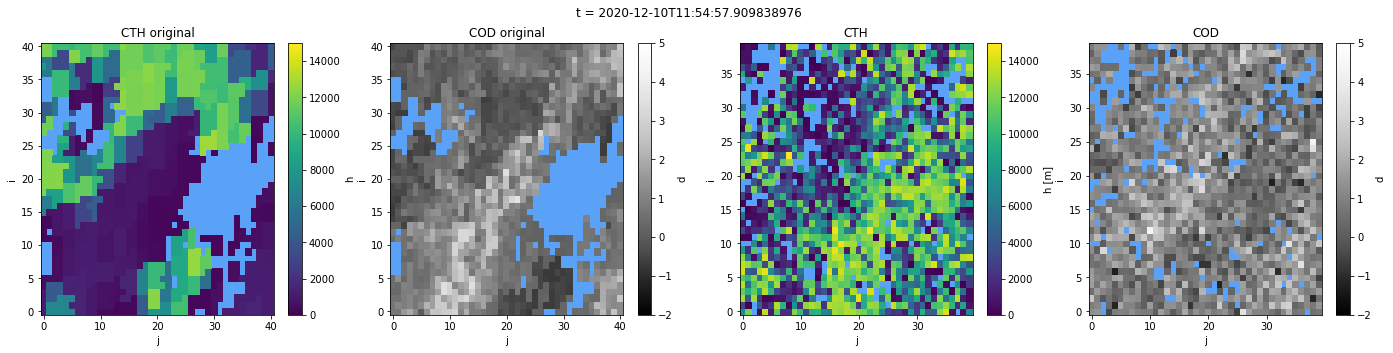

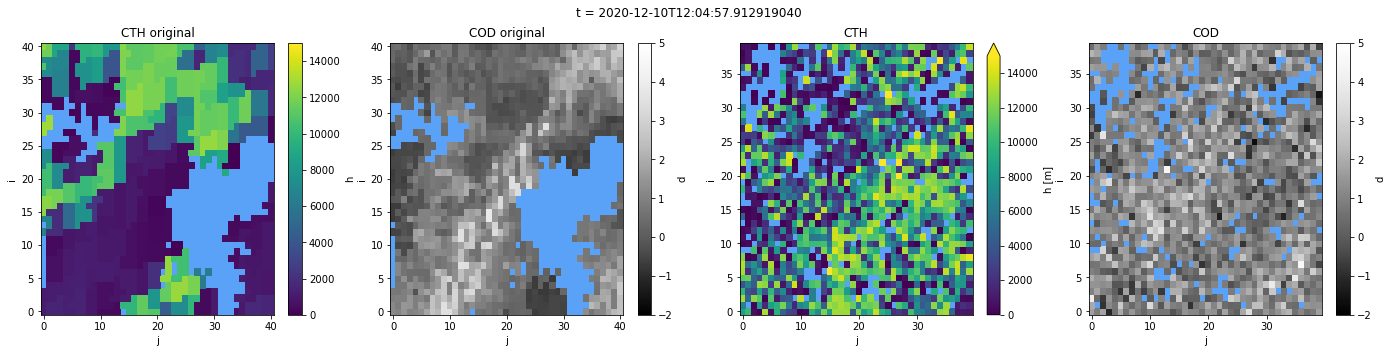

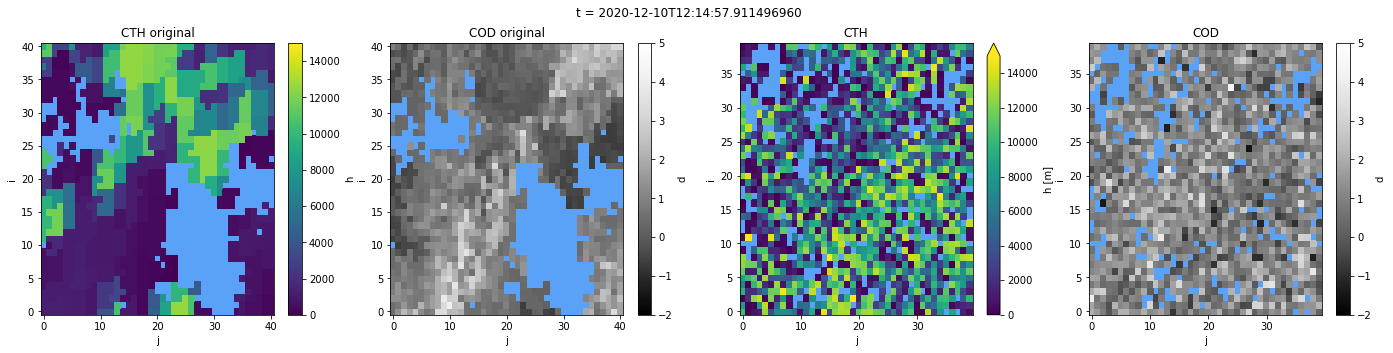

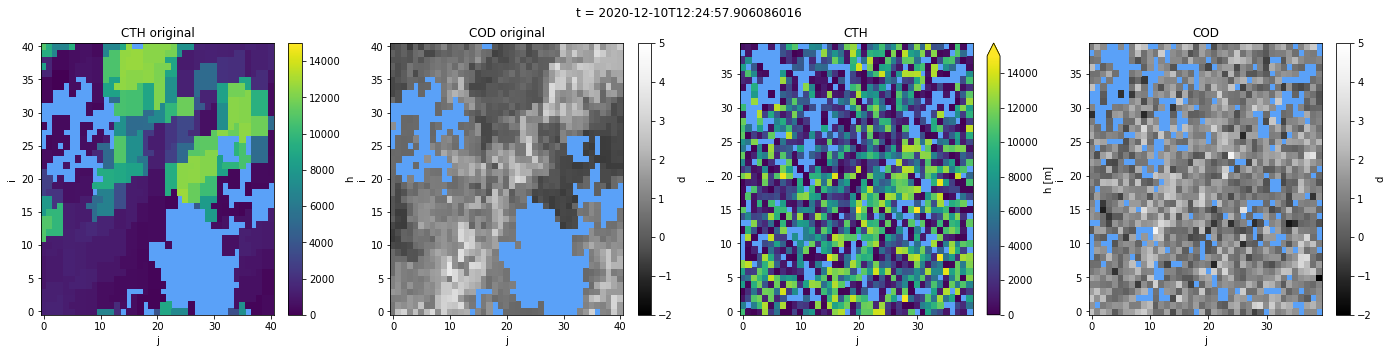

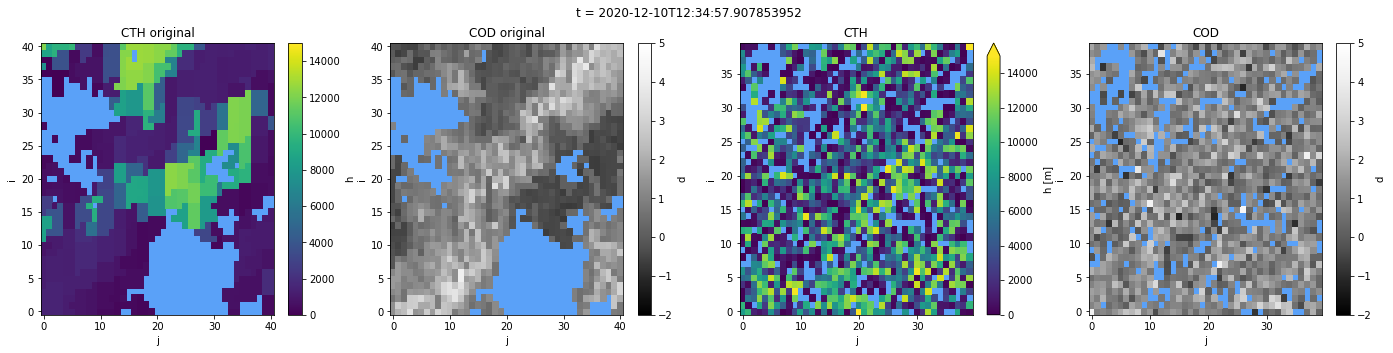

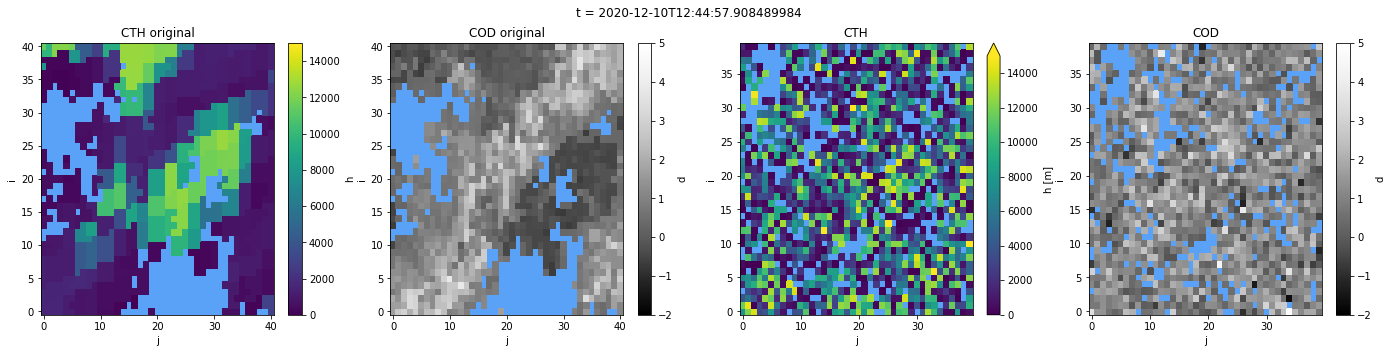

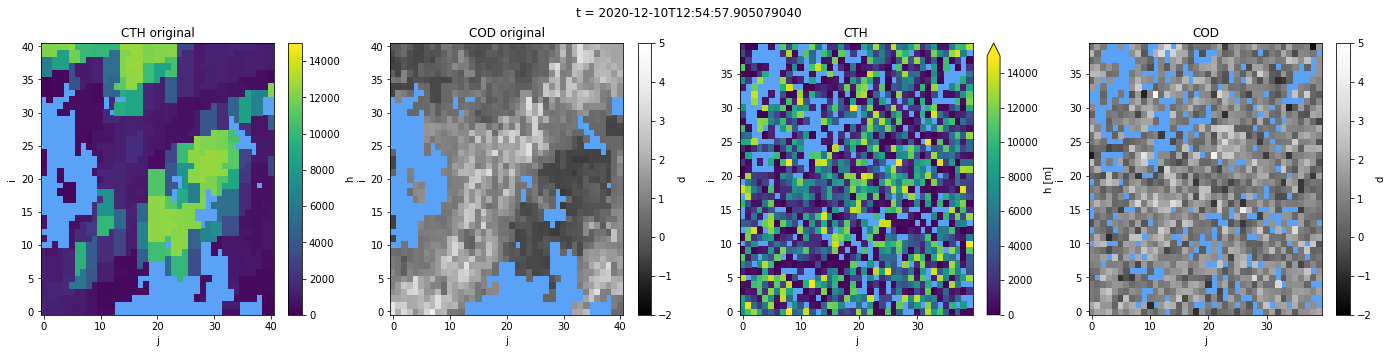

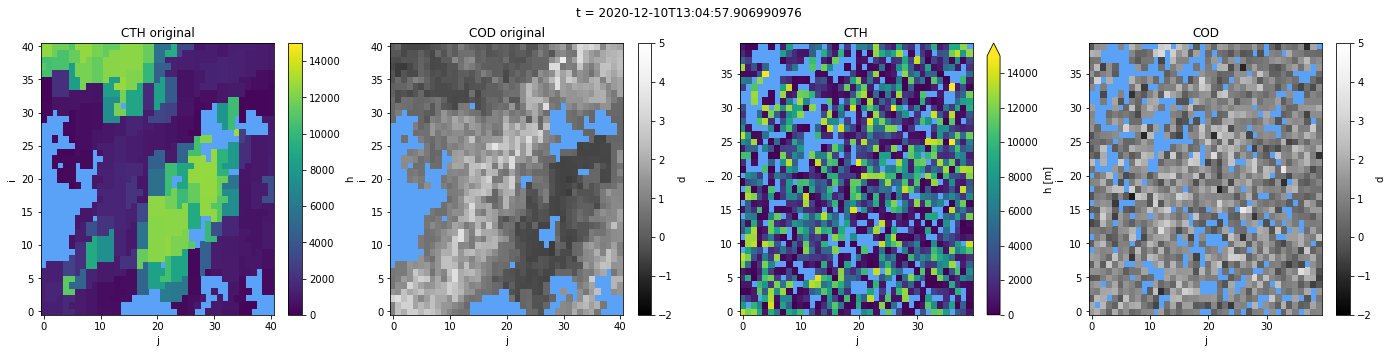

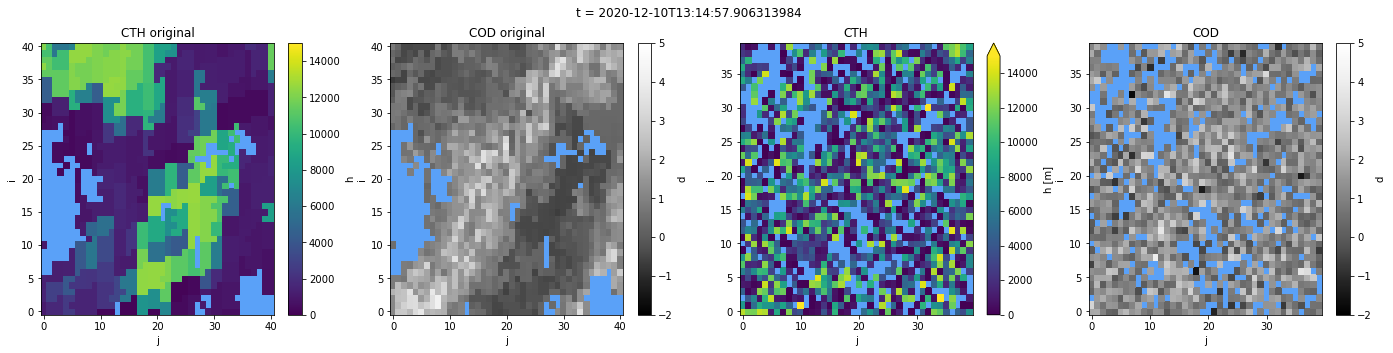

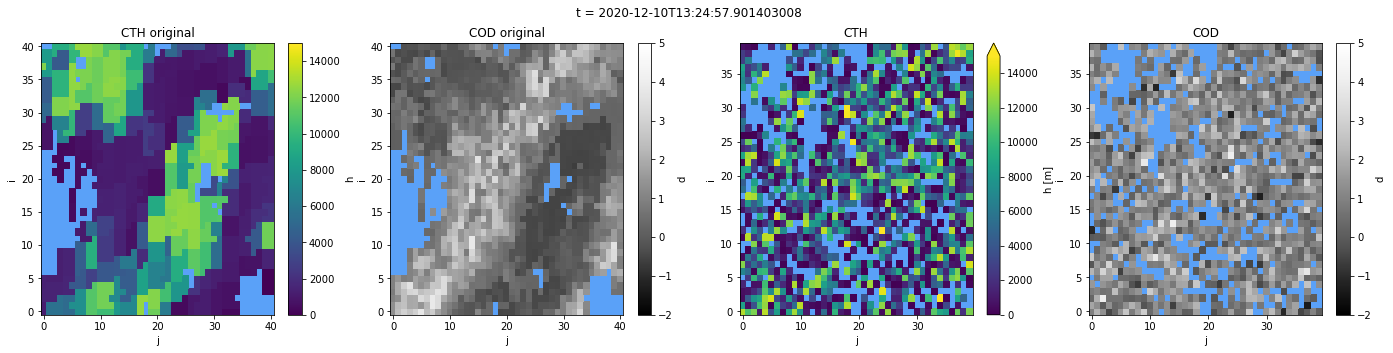

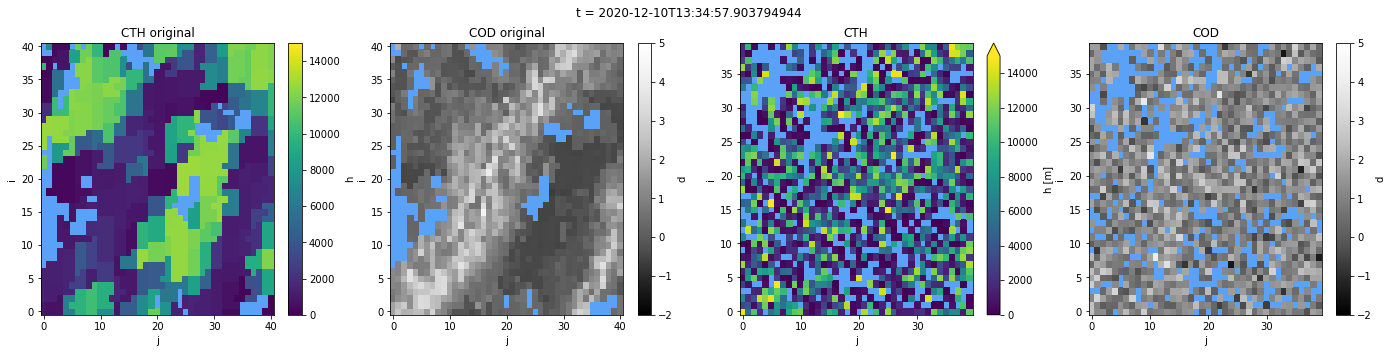

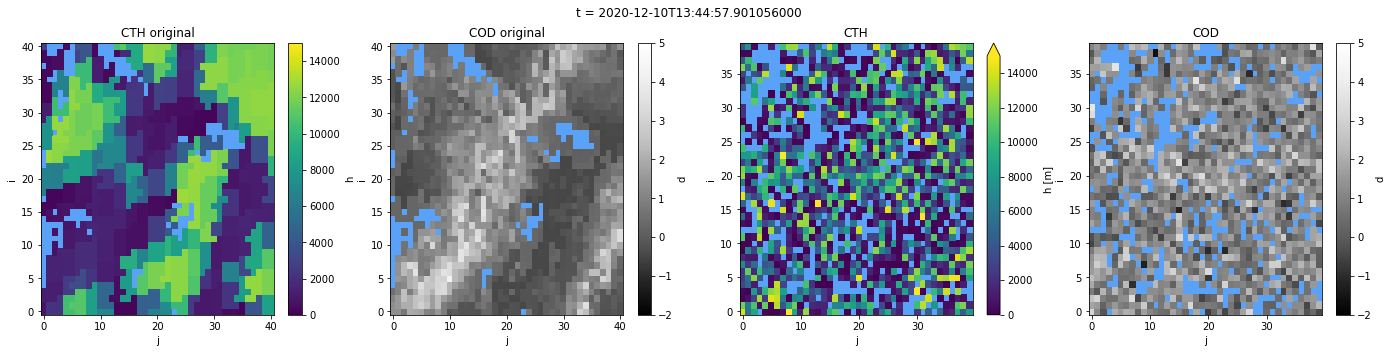

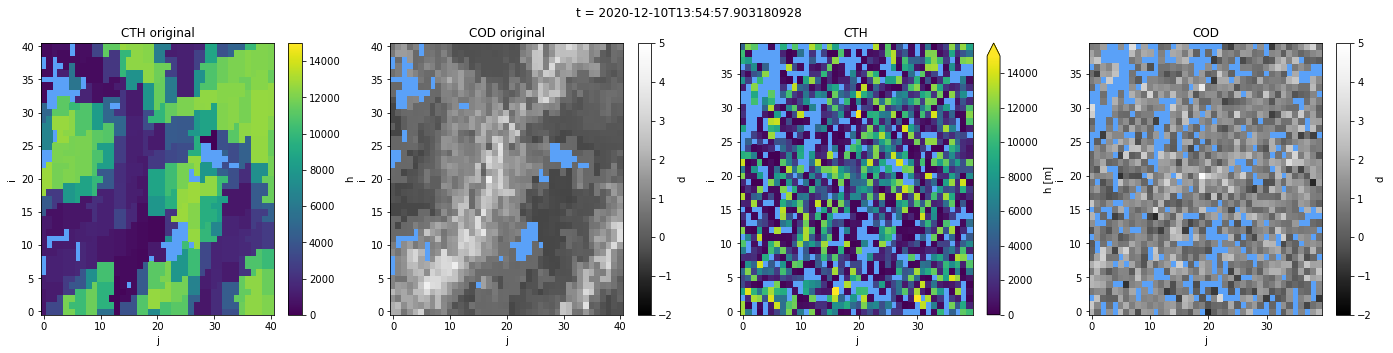

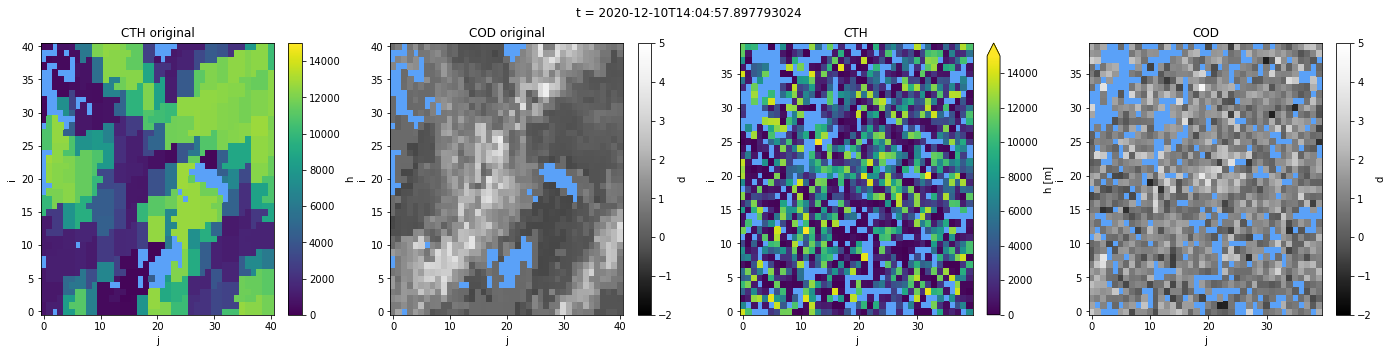

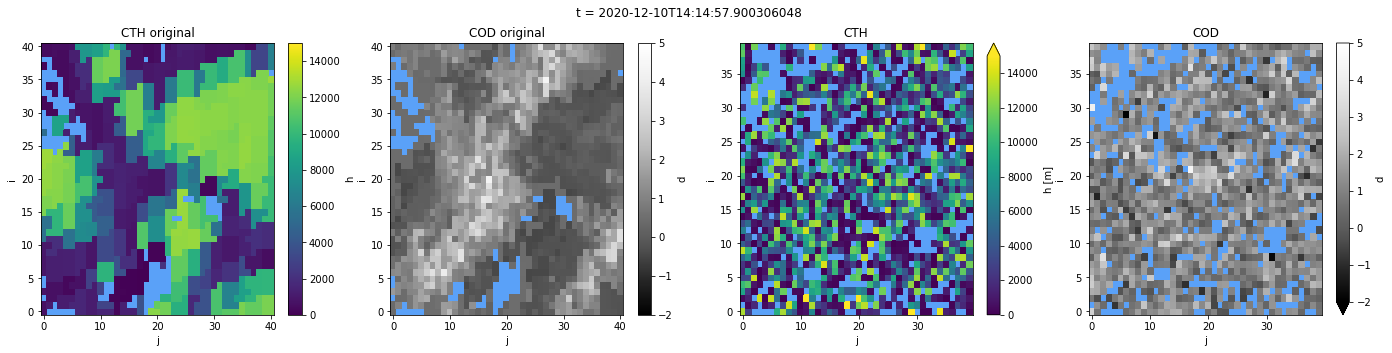

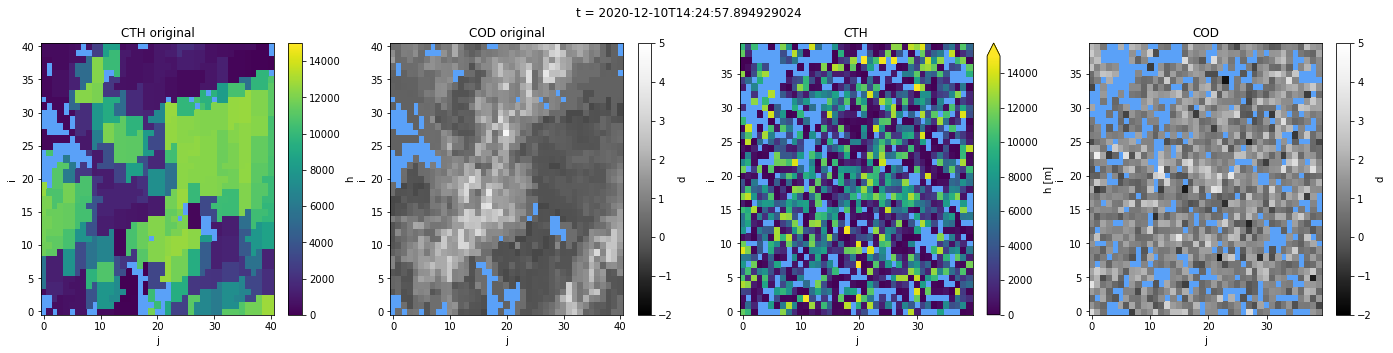

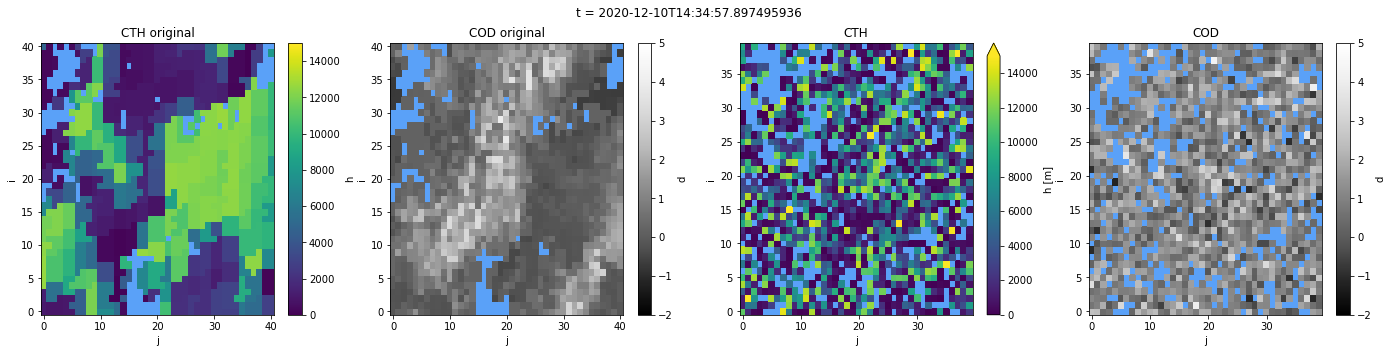

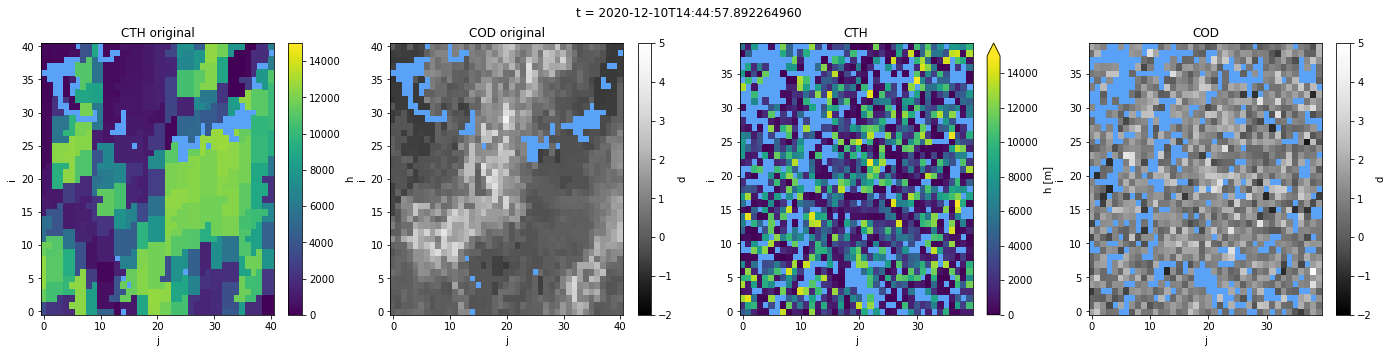

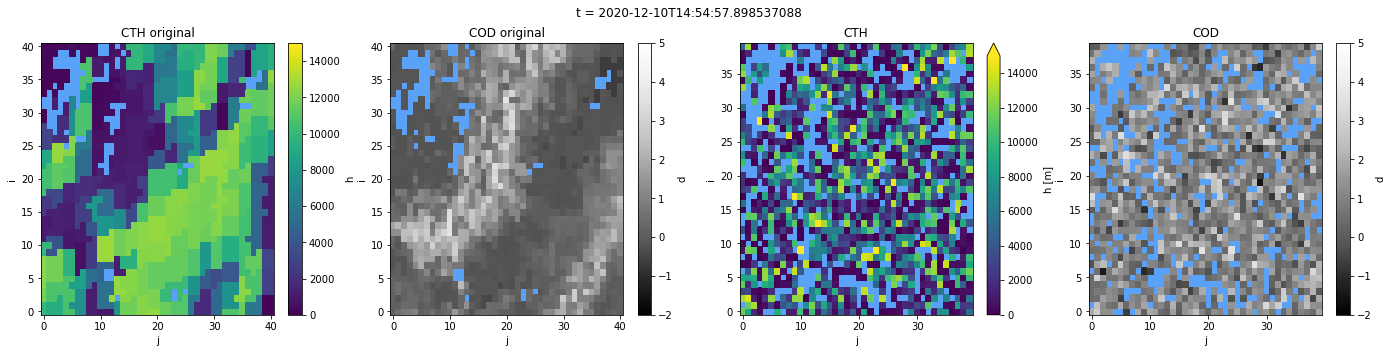

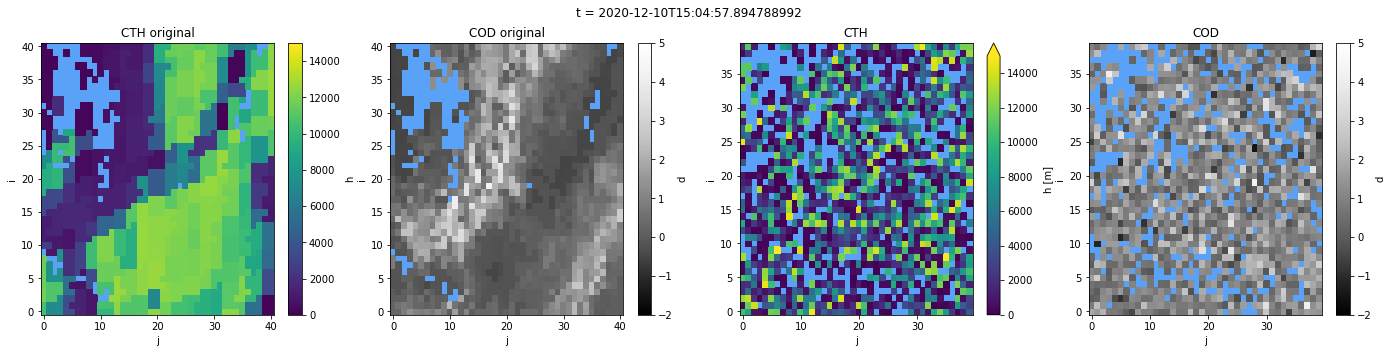

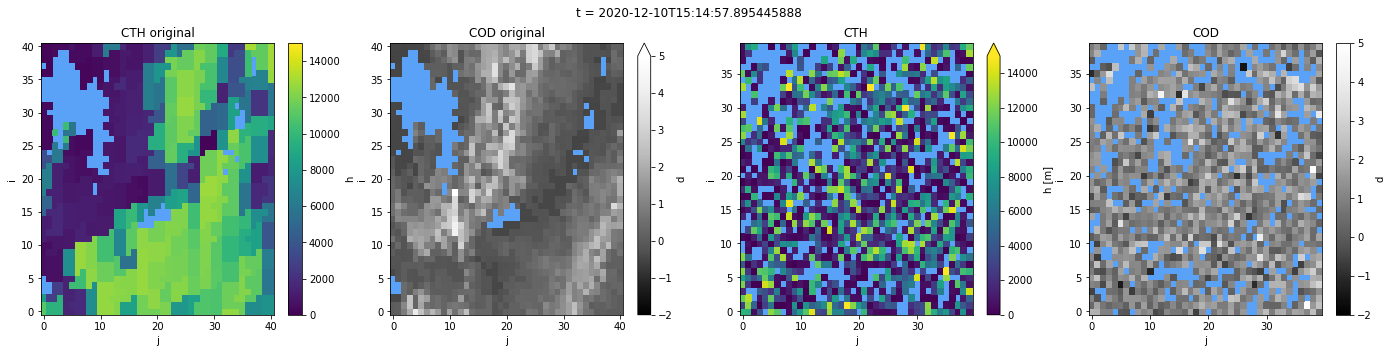

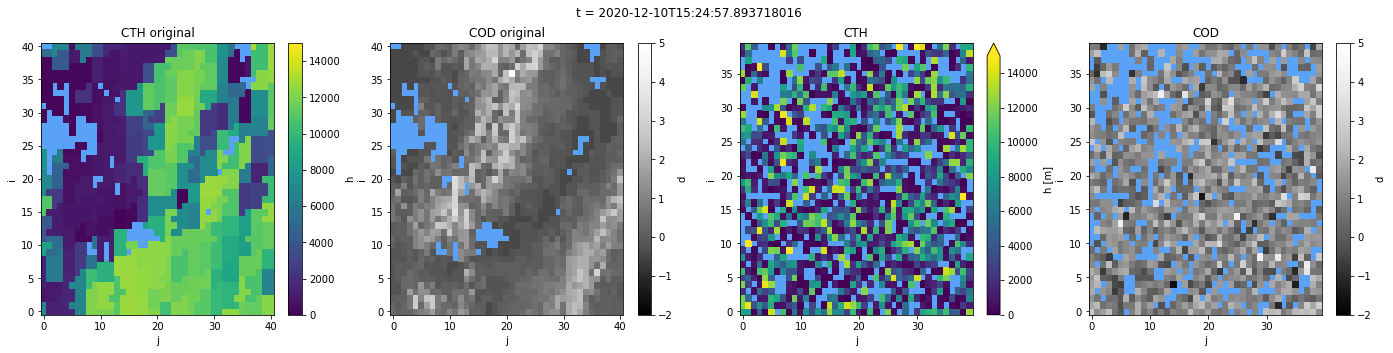

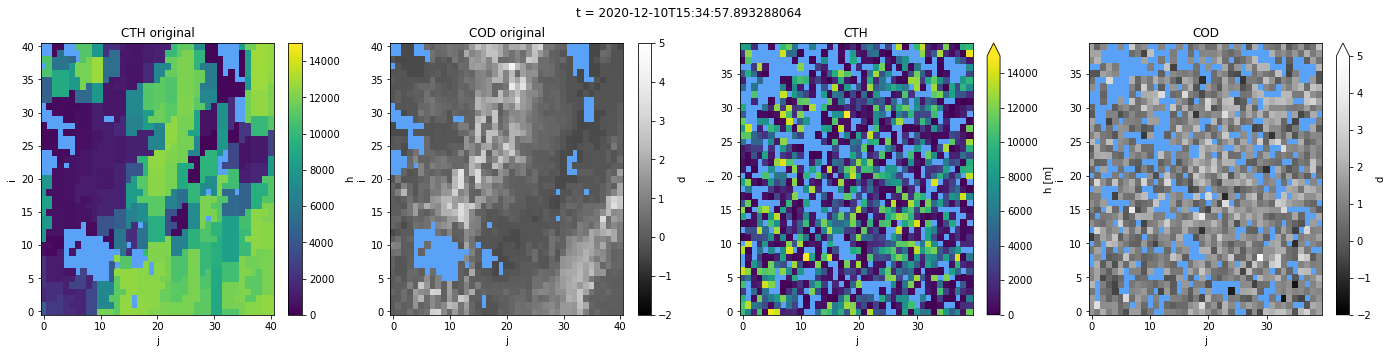

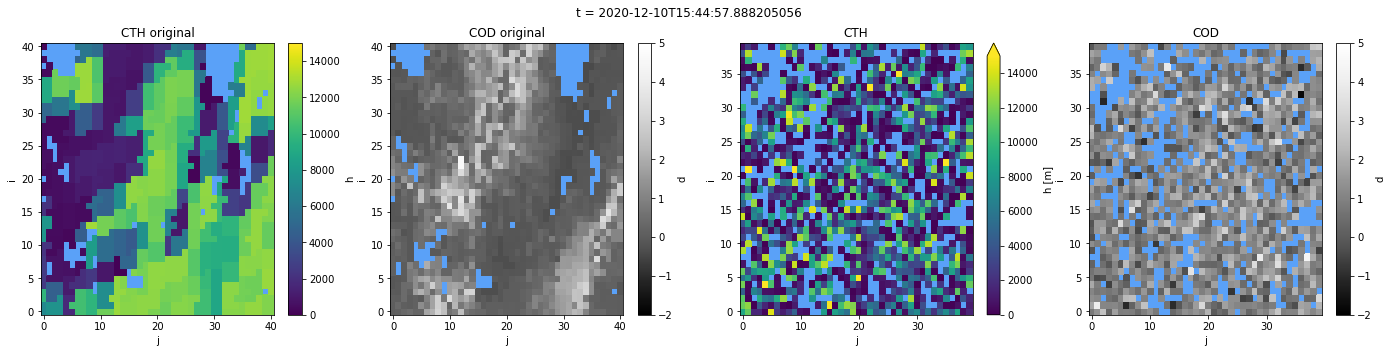

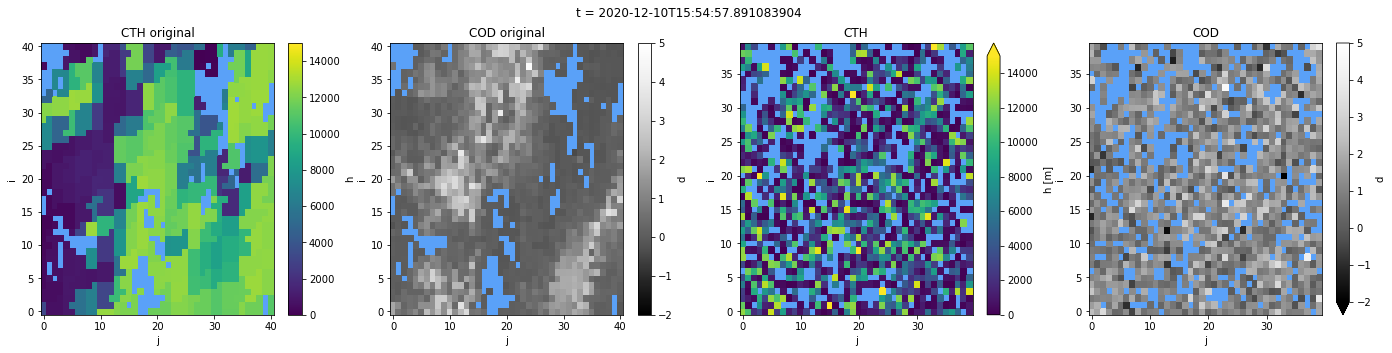

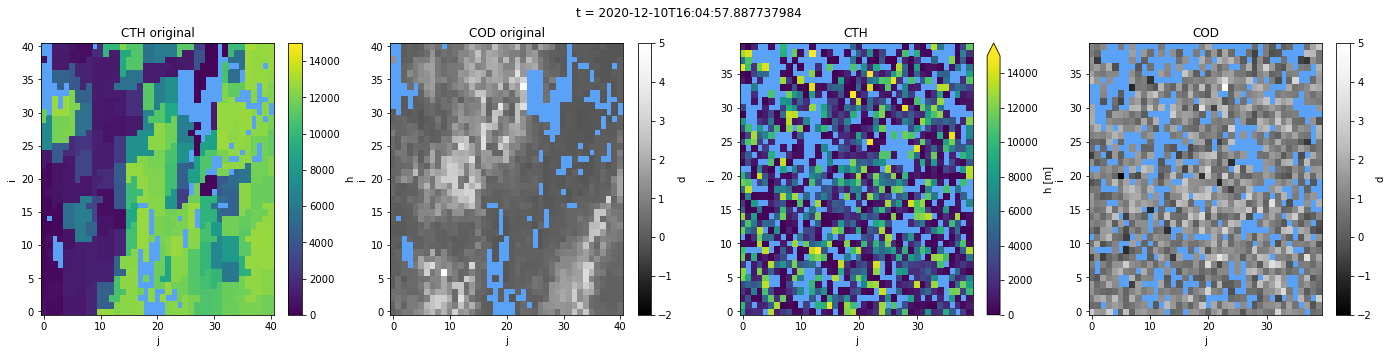

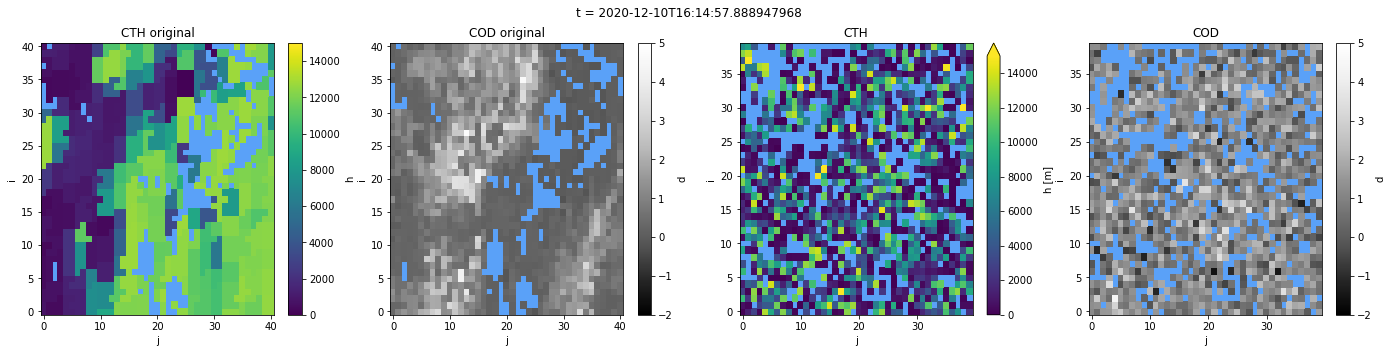

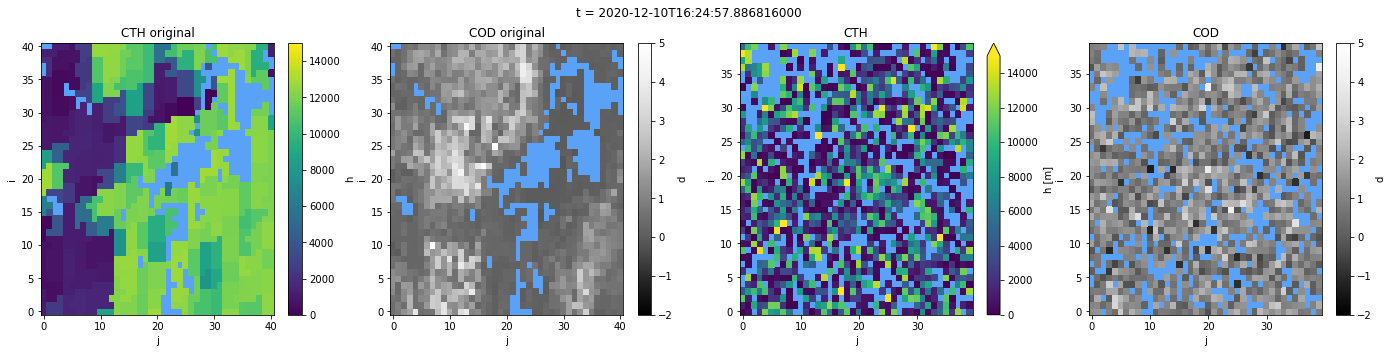

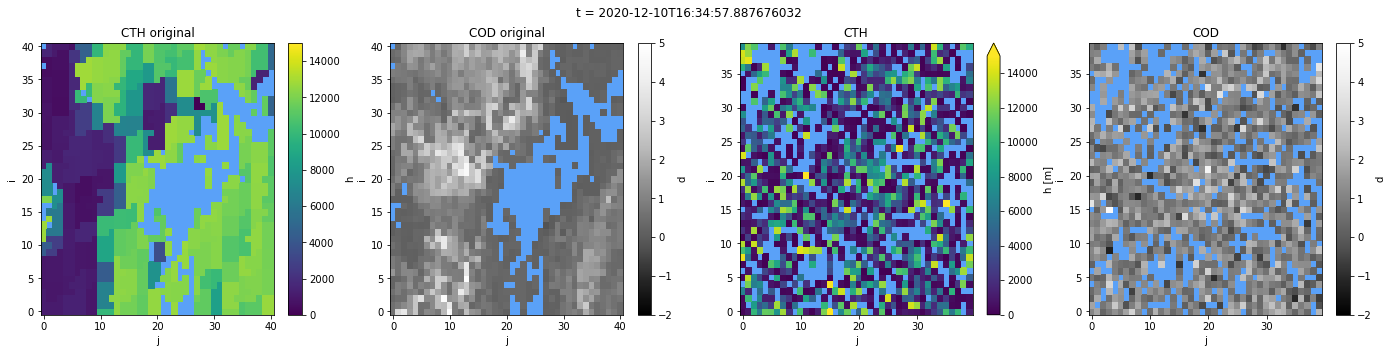

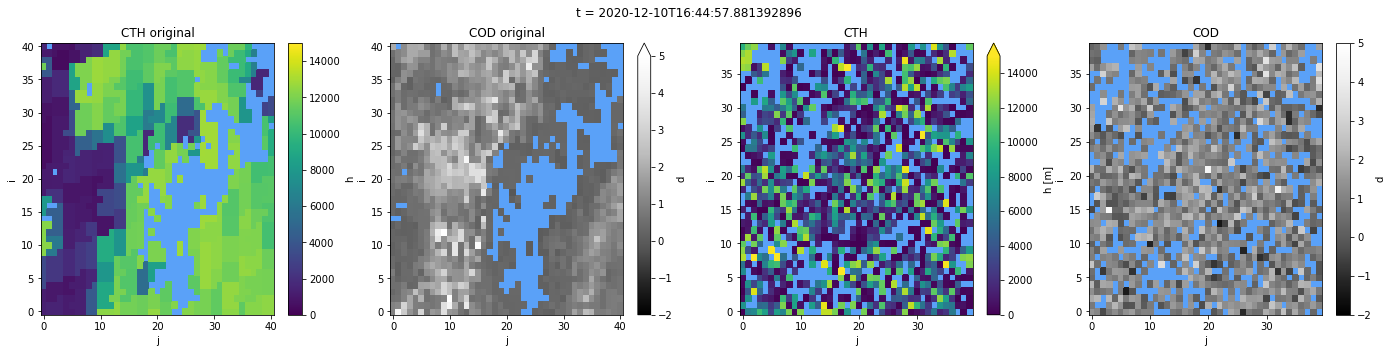

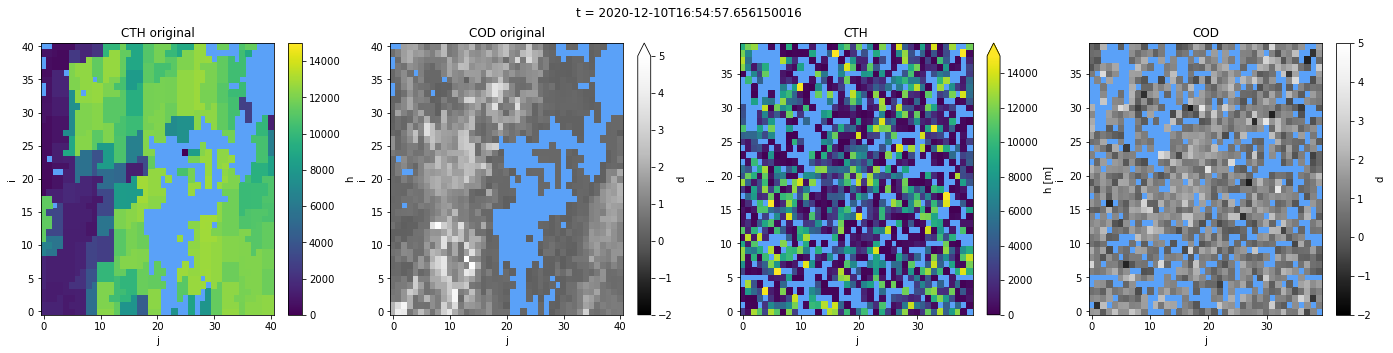

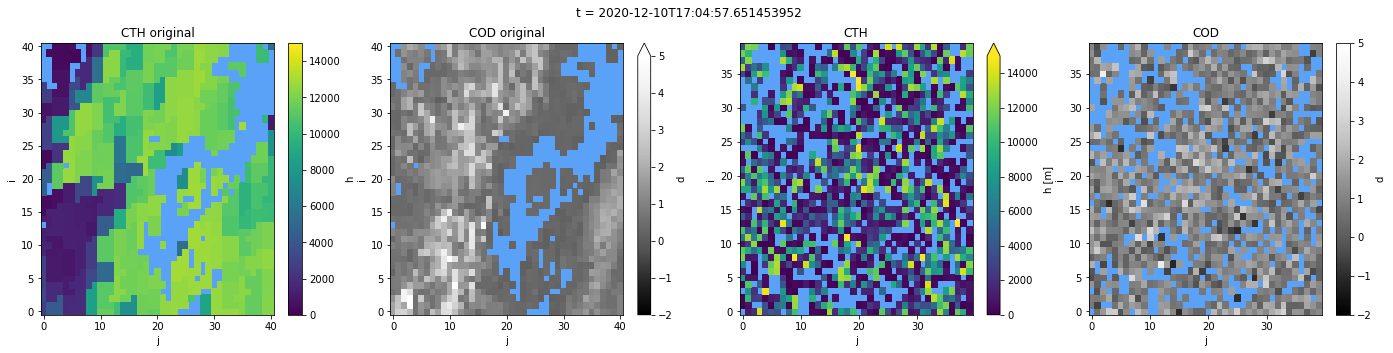

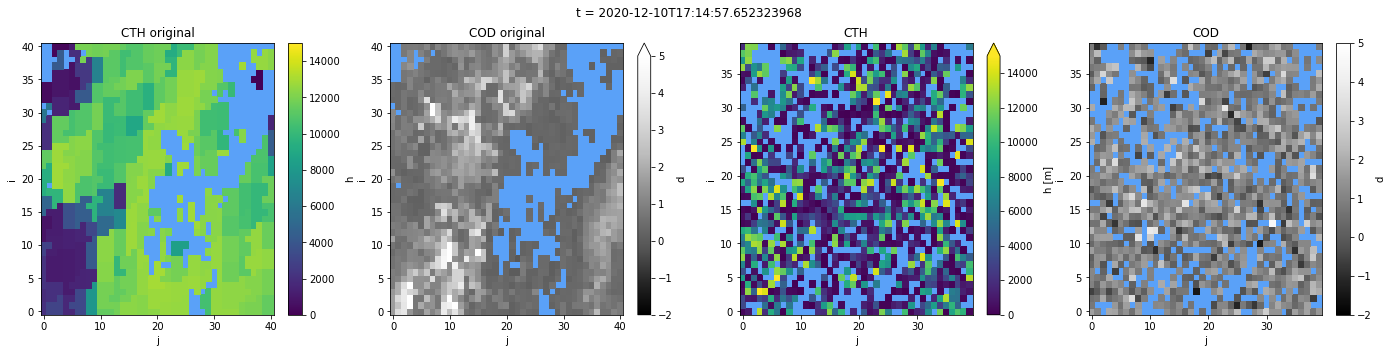

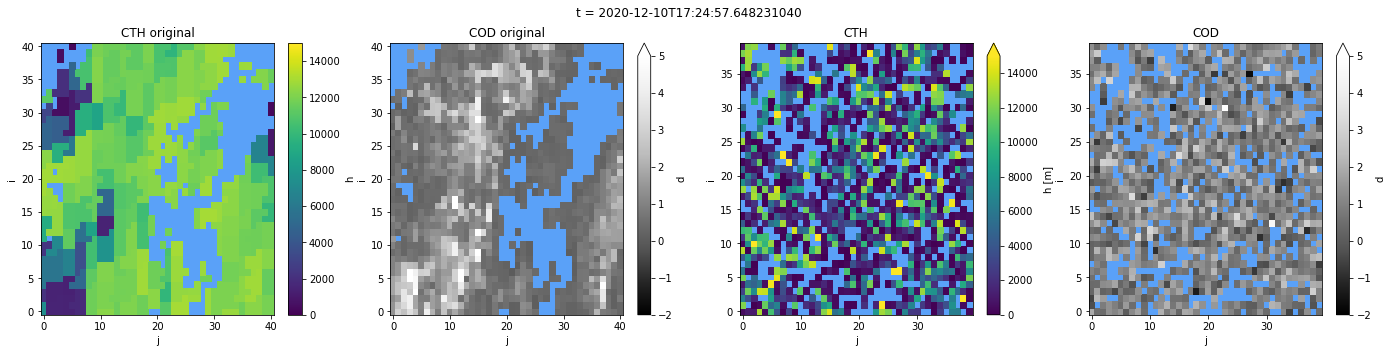

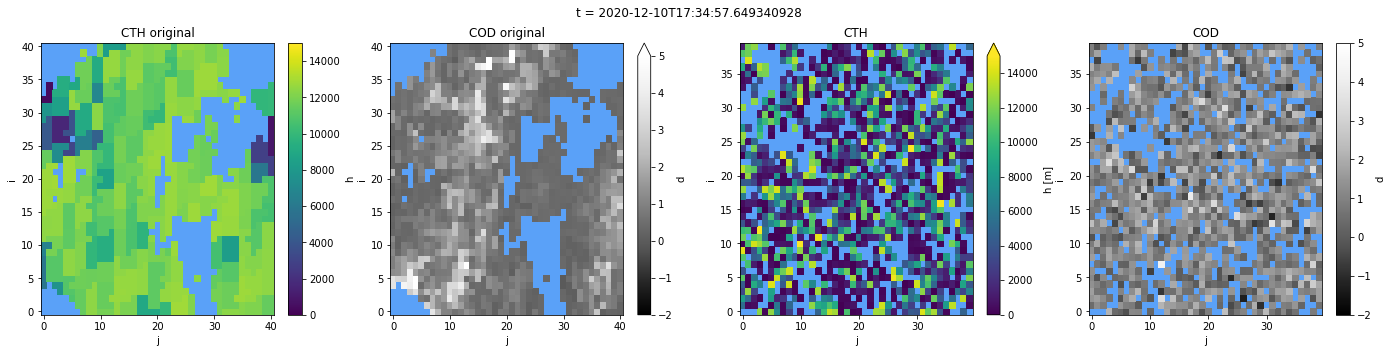

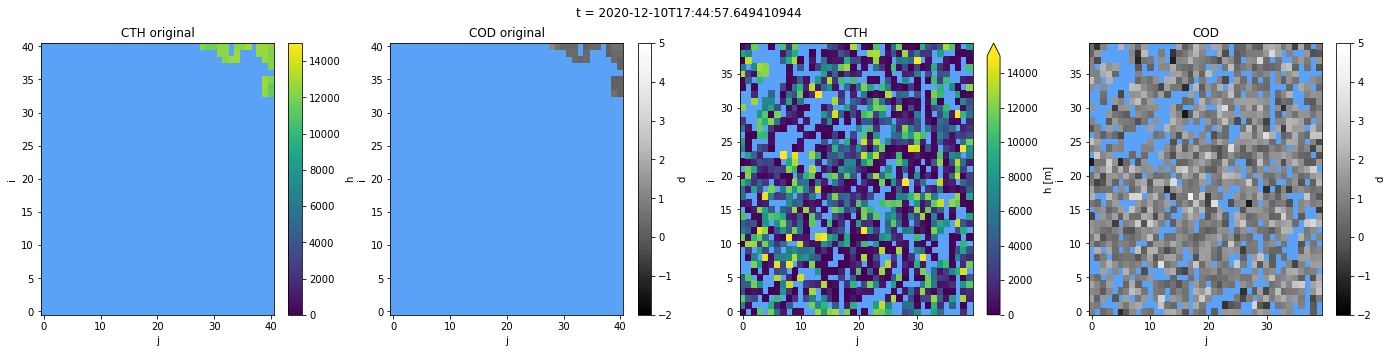

IndexError: index 39 is out of bounds for axis 0 with size 39

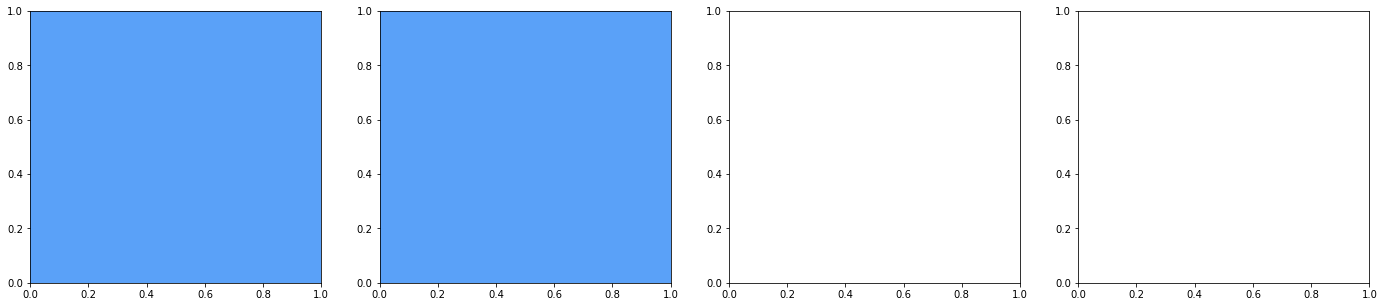

In [28]:
# xr.plot.imshow(ds.RGB_colorbar)
# plt.show()
# X = Xo

hlim = [0, 15e3]
dlim = [-2, 5]

for t in X.t.data:
    fig, ax = plt.subplots(1,4, figsize = (24, 5))
#     xr.plot.imshow(X.loc[dict(t = t)].RGB,
#                    ax = ax[0]
#                   )
    ax[0].patch.set_facecolor('#5AA1F8')
    ax[1].patch.set_facecolor('#5AA1F8')
    
    images.sel(t = images.t[t], i = slice(40), j = slice(40)).h.plot(ax = ax[0], vmin = hlim[0], vmax = hlim[1])
    images.sel(t = images.t[t], i = slice(40), j = slice(40)).d.plot(ax = ax[1], cmap = cm.Greys_r, vmin = dlim[0], vmax = dlim[1]) 
    
    ax[0].set_title('CTH original')
    ax[1].set_title('COD original')
    
    
    ax[2].patch.set_facecolor('#5AA1F8')
    ax[3].patch.set_facecolor('#5AA1F8')
    
    X.sel(t = t).h.plot(ax = ax[2], vmin = hlim[0], vmax = hlim[1])
    X.sel(t = t).d.plot(ax = ax[3], cmap = cm.Greys_r, vmin = dlim[0], vmax = dlim[1]) 
    
    ax[2].set_title('CTH')
    ax[3].set_title('COD')
    
    plt.suptitle(f't = {images.t[t].data}')
    plt.savefig(f'../fig/model2/sim_model2_test={t}.png')
    plt.show()
    

    


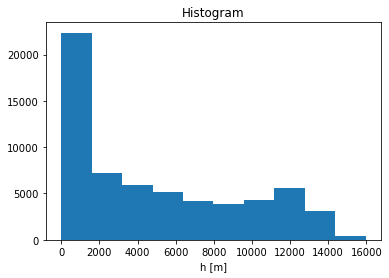

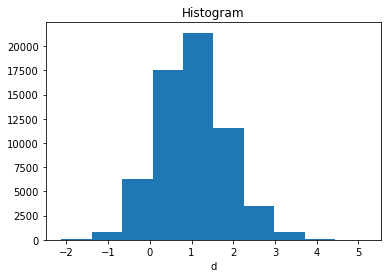

In [9]:
X.h.plot()
plt.show()
X.d.plot()
plt.show()


# Xo.h.plot()
# plt.show()
# Xo.d.plot()
# plt.show()